In [3]:
# General Imports
import numpy as np
import matplotlib.pyplot as plt

# Astronomy Specific Imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

# Image Analysis Specific Imports
from scipy.ndimage import label
from skimage.measure import perimeter,euler_number


def standard_minkowski_functionals(data, threshold_min = 1e20, threshold_max=1e22, thresholds = None):

    if thresholds is None:
        thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Store Minkowski Functional values
    areas = []
    perimeters = []
    euler_chars = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1)
        perim = perimeter(mask)
        perimeters.append(perim)

        # Compute Euler Characteristic (v2)
        euler_char = euler_number(mask)
        euler_chars.append(euler_char)


    # Convert to log scale for fractal dimension analysis
    log_areas = np.log10(areas)
    log_perimeters = np.log10(np.array(perimeters))

    D = (2* log_perimeters)/(log_areas)

    return {
        "thresholds": thresholds,
        "values": [areas, perimeters, euler_chars, D]
    }

def box_counting_method(mask):
    """Estimate the fractal dimension of a binary mask using the box-counting method."""
    binary_image = mask.astype(bool)  # Ensure it's a boolean array
    
    # Define box sizes as powers of 2
    min_box_size = 2
    max_box_size = min(mask.shape) // 2
    box_sizes = np.unique(2**np.arange(np.log2(min_box_size), np.log2(max_box_size) + 1).astype(int))

    counts = []
    for size in box_sizes:
        count = 0
        for x in range(0, mask.shape[0], size):
            for y in range(0, mask.shape[1], size):
                sub_mask = binary_image[x:x+size, y:y+size]
                if np.any(sub_mask):  # Only count non-empty boxes
                    count += 1
        counts.append(count)

    # Remove zero counts to avoid log issues
    valid_indices = np.array(counts) > 0
    log_box_sizes = np.log(box_sizes[valid_indices])
    log_counts = np.log(np.array(counts)[valid_indices])

    # Perform linear fit
    coeffs = np.polyfit(log_box_sizes, log_counts, 1)
    fractal_dimension = -coeffs[0]

    return fractal_dimension

## **Simulations with Simple Geometrical/Topological Features**

### **1: Line**

A line should return a (fractal) dimension of **D = 1**. Using the Box-Counting Method, we do indeed obtain this result. However, the Perimeter-Area (PA) relation presents a different picture. This discrepancy arises due to the inherent anti-correlation in the PA formula:

$$ A \propto k \cdot P^{2/D} $$

For a line:
- **Area:** $ A = 1 \cdot l $
- **Perimeter:** $ P = l $
- **Proportionality factor:** $ k = 1 $

Substituting these values:

$$ l \propto l^{2/D} $$

Solving for $ D $, we find that the PA method returns **D = 2**, highlighting the built-in anti-correlation of the formula.


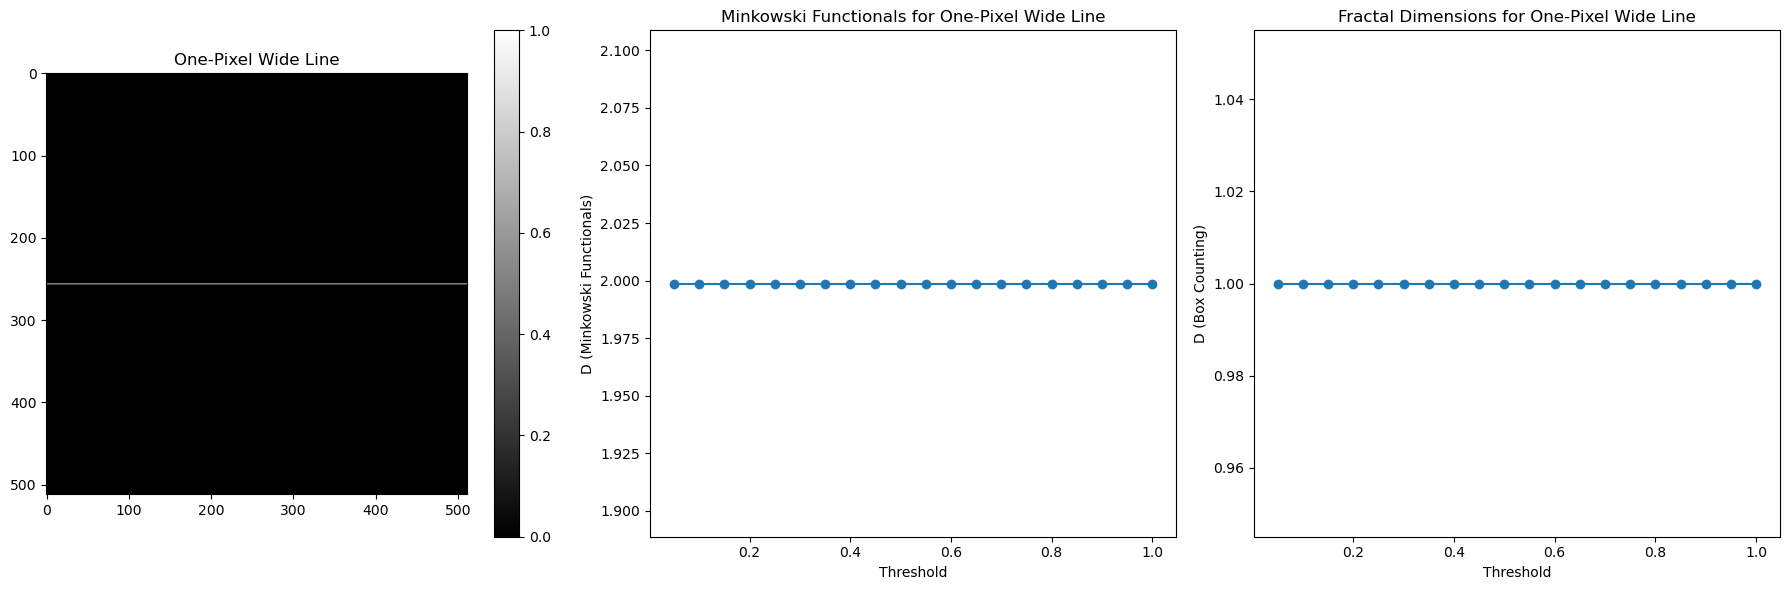

In [4]:
shape = (512, 512)

# Create a binary image with a one-pixel wide line
line_image = np.zeros(shape, dtype=bool)
line_image[shape[0] // 2, :] = 1  # Horizontal line in the middle

# Display the line image
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(line_image, cmap='gray')
plt.title('One-Pixel Wide Line')
plt.colorbar()

# Calculate Minkowski functionals for the line image
line_thresholds = np.linspace(0.05, 1, 20)
results = standard_minkowski_functionals(line_image.astype(float), thresholds=line_thresholds)

plt.subplot(1, 3, 2)
plt.plot(line_thresholds, ((results["values"][3])), "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Minkowski Functionals)')
plt.title('Minkowski Functionals for One-Pixel Wide Line')

# # Calculate fractal dimensions using box counting method
line_fractal_dimensions = []
for threshold in line_thresholds:
    line_fractal_dimensions.append(box_counting_method(line_image >= threshold))

plt.subplot(1, 3, 3)
plt.plot(line_thresholds, line_fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.title('Fractal Dimensions for One-Pixel Wide Line')

plt.tight_layout()
plt.show()

### **2: A Filled Plane**

For a plane, we expect a (fractal) dimension of **D = 2** with the Box-Counting Method and **D = 1** with the Perimeter-Area (PA) Method. The Box-Counting Method confirms this expectation, but the PA result appears slightly off.

This discrepancy arises because the formula:

$$ A = l^2 $$
$$ P = 4 \cdot l $$

Substituting these values:

$$ l^2 \propto l^{2/D} $$

hence **D = 2** in the PA relation. When substituted into the PA formula, this leads to an unexpected result of around 1.22. However, when using the corrected implementation in `plane_corrected_minkowski_functionals`, which includes the proportionality factor $k$, we obtain exactly the expected values: **D = 2** for the Box-Counting Method and **D = 1** for the PA Method.

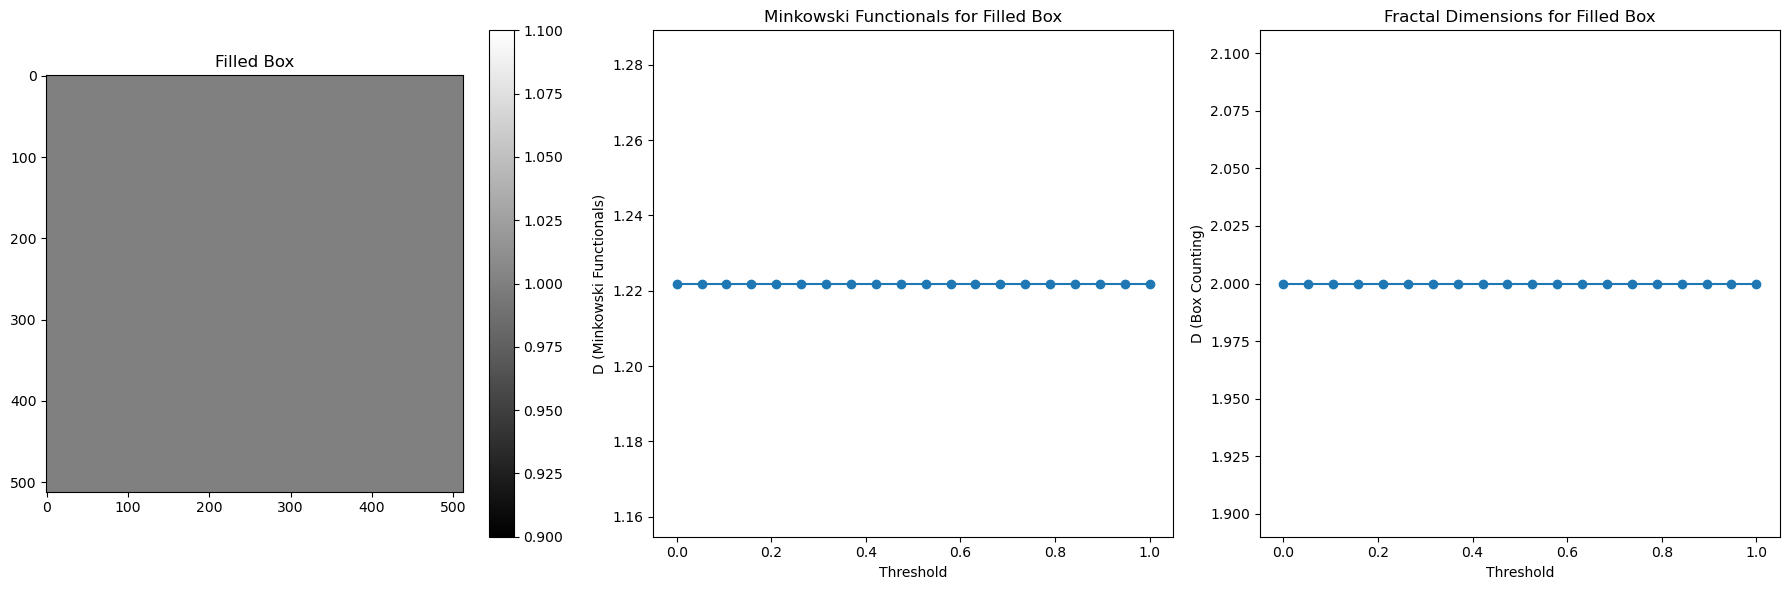

In [5]:
# not corrected
shape = (512, 512)

# Create a binary image with a filled box
box_image = np.ones(shape, dtype=bool)

# Display the box image and its analyses in a (1, 3) subplot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(box_image, cmap='gray')
plt.title('Filled Box')
plt.colorbar()

# Calculate Minkowski functionals for the box image
box_thresholds = np.linspace(0, 1, 20)
box_results = standard_minkowski_functionals(box_image.astype(float), thresholds=box_thresholds)

plt.subplot(1, 3, 2)
plt.plot(box_thresholds, box_results["values"][3], "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Minkowski Functionals)')
plt.title('Minkowski Functionals for Filled Box')

# Calculate fractal dimensions using box counting method
box_fractal_dimensions = []
for threshold in box_thresholds:
    box_fractal_dimensions.append(box_counting_method(box_image >= threshold))

plt.subplot(1, 3, 3)
plt.plot(box_thresholds, box_fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.title('Fractal Dimensions for Filled Box')

plt.tight_layout()
plt.show()

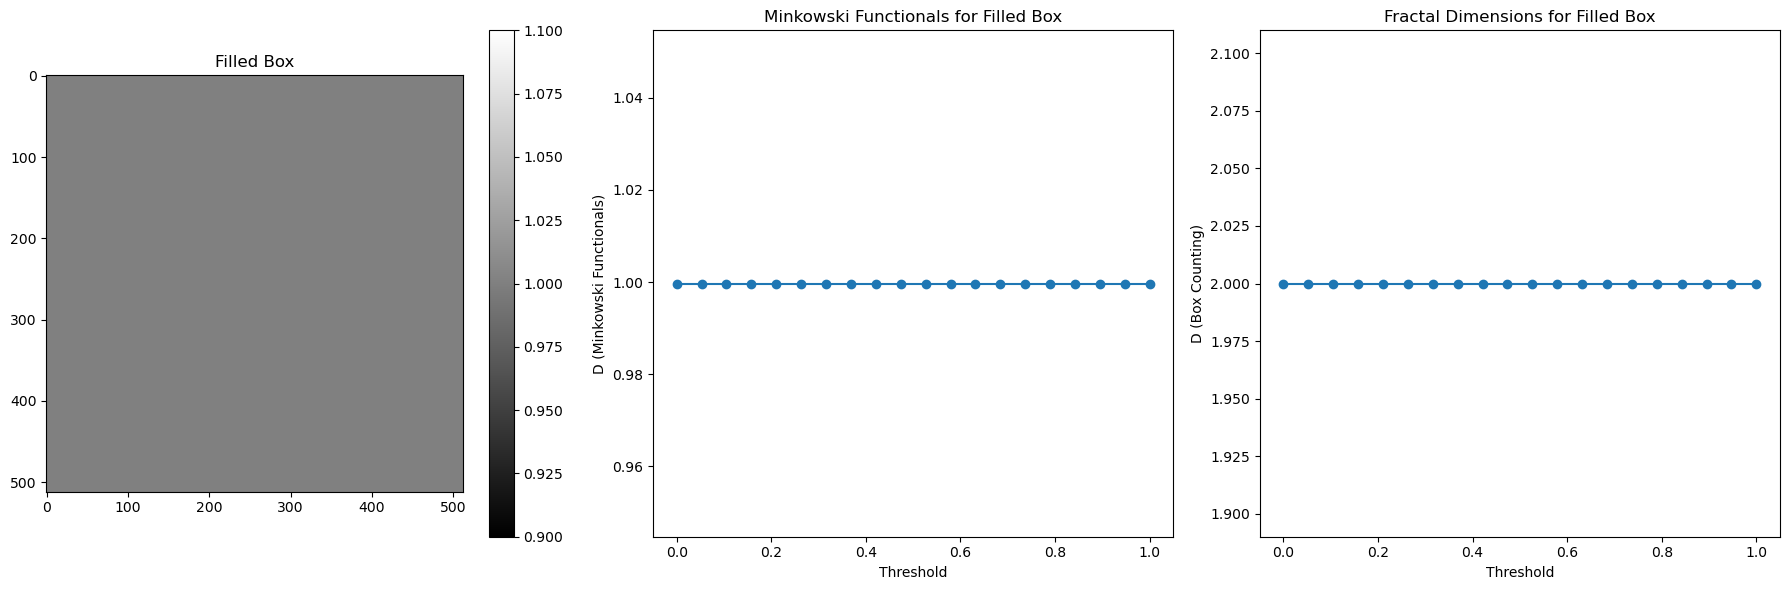

In [6]:
# correction for plane

def plane_corrected_minkowski_functionals(data, threshold_min = 1e20, threshold_max=1e22, thresholds = None):

    if thresholds is None:
        thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Store Minkowski Functional values
    areas = []
    perimeters = []
    euler_chars = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1) with correction for the plane dimension
        perim = perimeter(mask)/4
        perimeters.append(perim)

        # Compute Euler Characteristic (v2)
        euler_char = euler_number(mask)
        euler_chars.append(euler_char)

    # Convert to log scale for fractal dimension analysis
    log_areas = np.log10(areas)
    log_perimeters = np.log10(perimeters)

    D = 2*log_perimeters/log_areas

    return {
        "thresholds": thresholds,
        "values": [areas, perimeters, euler_chars, D]
    }

# Display the box image and its analyses in a (1, 3) subplot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(box_image, cmap='gray')
plt.title('Filled Box')
plt.colorbar()

# Calculate Minkowski functionals for the box image
box_thresholds = np.linspace(0, 1, 20)
box_results = plane_corrected_minkowski_functionals(box_image.astype(float), thresholds=box_thresholds)

plt.subplot(1, 3, 2)
plt.plot(box_thresholds, box_results["values"][3], "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Minkowski Functionals)')
plt.title('Minkowski Functionals for Filled Box')

# Calculate fractal dimensions using box counting method
box_fractal_dimensions = []
for threshold in box_thresholds:
    box_fractal_dimensions.append(box_counting_method(box_image >= threshold))

plt.subplot(1, 3, 3)
plt.plot(box_thresholds, box_fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.title('Fractal Dimensions for Filled Box')

plt.tight_layout()
plt.show()

### **3: A Circle**

The expected (fractal) dimension of a filled circle should be **D = 2** in the Box-Counting Method and **D = 1** in the Perimeter-Area (PA) relation.

For a circle:
- **Area:** $$ A = \pi r^2 $$
- **Perimeter:** $$ P = 2 \pi r $$

From which it follows that the dimension from the PA relation should be 1. This is achieved again with the correction involving the proportionality factor.

Also important: In the Box-Counting Method, we observe a dependence on the object's scale, returning different results if the circle is smaller or bigger. The Perimeter-Area method, however, is not affected by this.

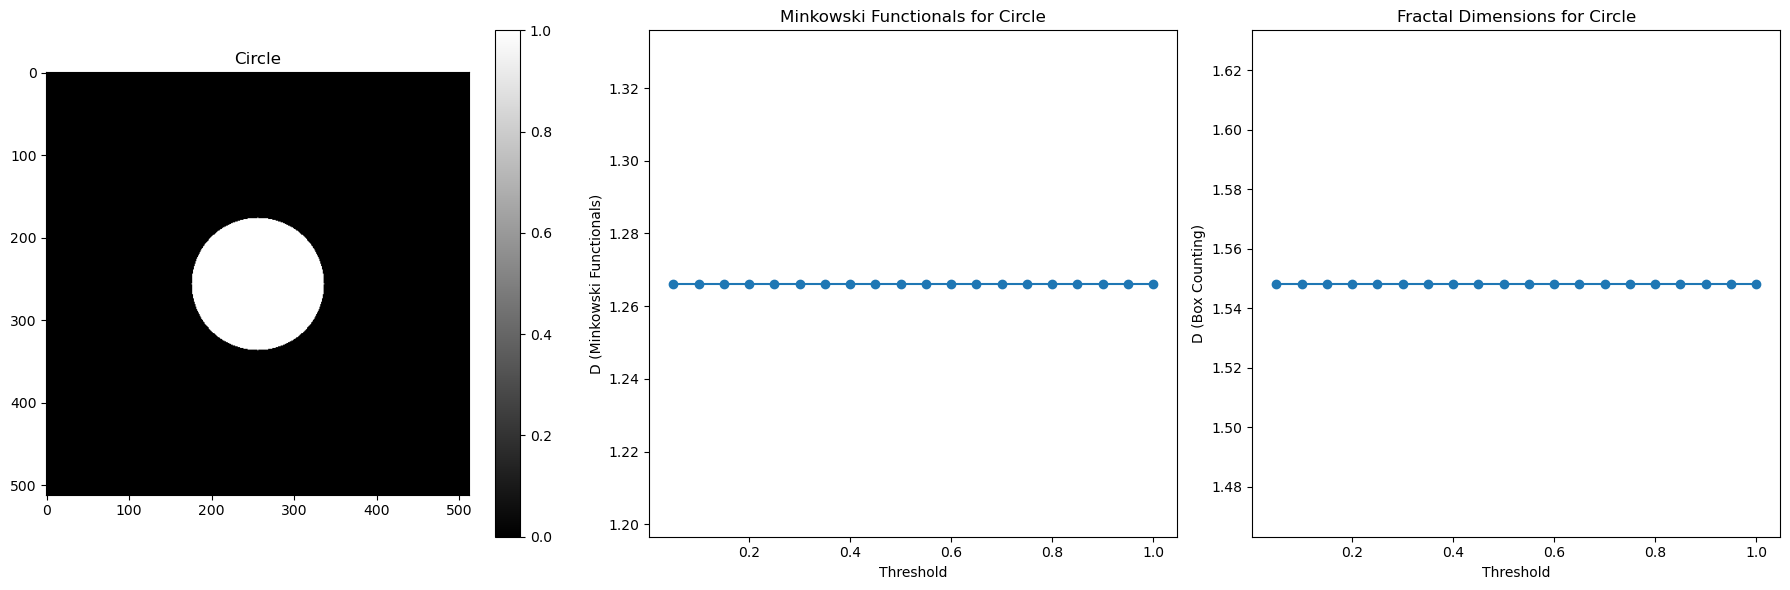

In [7]:
# Standard

# Create a binary image with a circle
circle_image = np.zeros(shape, dtype=bool)
rr, cc = np.ogrid[:shape[0], :shape[1]]
circle_center = (shape[0] // 2, shape[1] // 2)
circle_radius = 80
circle_image[(rr - circle_center[0])**2 + (cc - circle_center[1])**2 <= circle_radius**2] = 1

# Display the circle image and its analyses in a (1, 3) subplot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(circle_image, cmap='gray')
plt.title('Circle')
plt.colorbar()

# Calculate Minkowski functionals for the circle image
circle_thresholds = np.linspace(0.05, 1, 20)
circle_results = standard_minkowski_functionals(circle_image.astype(float), thresholds=circle_thresholds)

plt.subplot(1, 3, 2)
plt.plot(circle_thresholds, ((circle_results["values"][3])), "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Minkowski Functionals)')
plt.title('Minkowski Functionals for Circle')

# Calculate fractal dimensions using box counting method
circle_fractal_dimensions = []
for threshold in circle_thresholds:
    circle_fractal_dimensions.append(box_counting_method(circle_image >= threshold))

plt.subplot(1, 3, 3)
plt.plot(circle_thresholds, circle_fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.title('Fractal Dimensions for Circle')

plt.tight_layout()
plt.show()

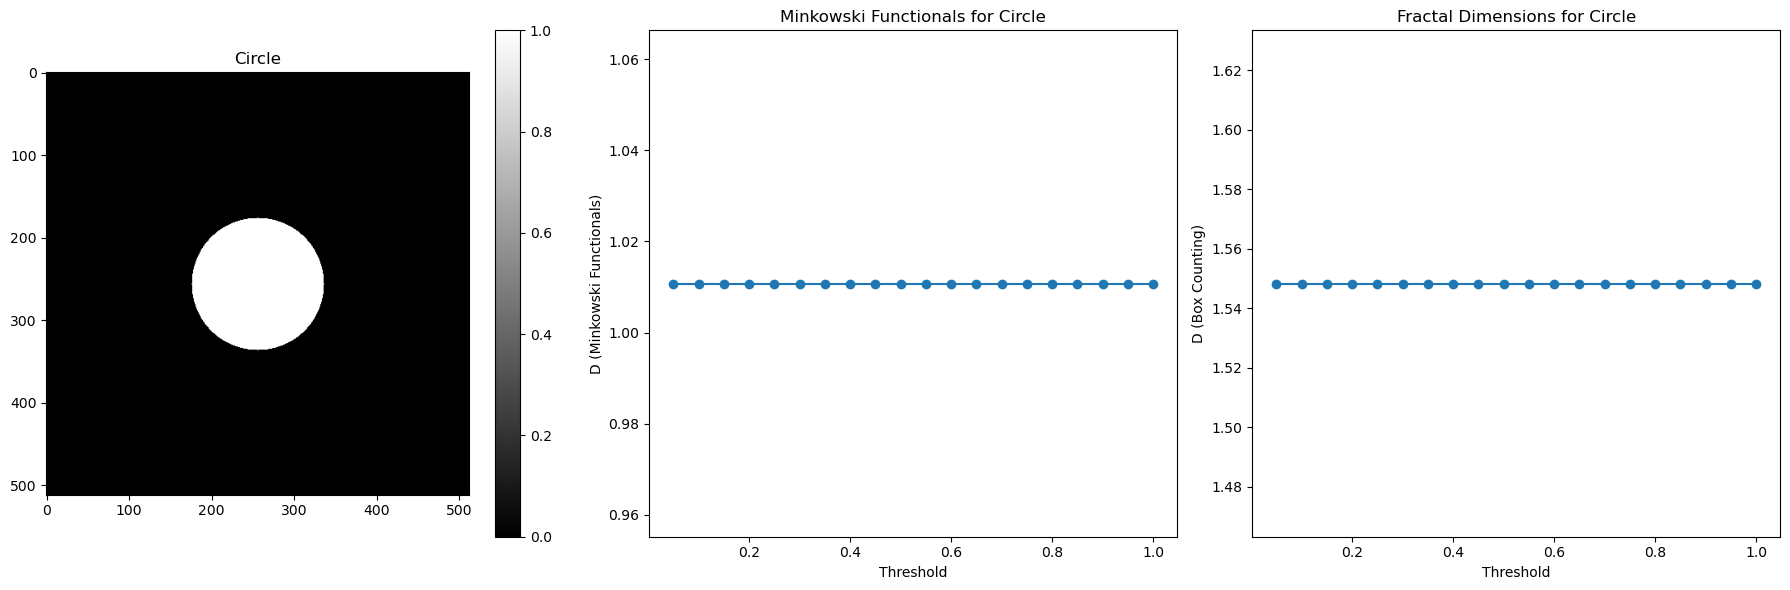

In [8]:
# Intercept corrected circle

def circle_corrected_minkowski_functionals(data, threshold_min = 1e20, threshold_max=1e22, thresholds = None):

    if thresholds is None:
        thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Store Minkowski Functional values
    areas = []
    perimeters = []
    euler_chars = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1) with correction for the plane dimension
        perim = perimeter(mask)
        perimeters.append(perim)

        # Compute Euler Characteristic (v2)
        euler_char = euler_number(mask)
        euler_chars.append(euler_char)

    # Convert to log scale for fractal dimension analysis
    log_areas = np.log10(areas)
    log_perimeters = np.log10(perimeters)

    D = 2*(log_perimeters - np.log10(2*np.sqrt(np.pi)))/(log_areas)

    return {
        "thresholds": thresholds,
        "values": [areas, perimeters, euler_chars, D]
    }

# Display the circle image and its analyses in a (1, 3) subplot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(circle_image, cmap='gray')
plt.title('Circle')
plt.colorbar()

# Calculate Minkowski functionals for the circle image
circle_thresholds = np.linspace(0.05, 1, 20)
circle_results = circle_corrected_minkowski_functionals(circle_image.astype(float), thresholds=circle_thresholds)

plt.subplot(1, 3, 2)
plt.plot(circle_thresholds, ((circle_results["values"][3])), "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Minkowski Functionals)')
plt.title('Minkowski Functionals for Circle')

# Calculate fractal dimensions using box counting method
circle_fractal_dimensions = []
for threshold in circle_thresholds:
    circle_fractal_dimensions.append(box_counting_method(circle_image >= threshold))

plt.subplot(1, 3, 3)
plt.plot(circle_thresholds, circle_fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.title('Fractal Dimensions for Circle')

plt.tight_layout()
plt.show()

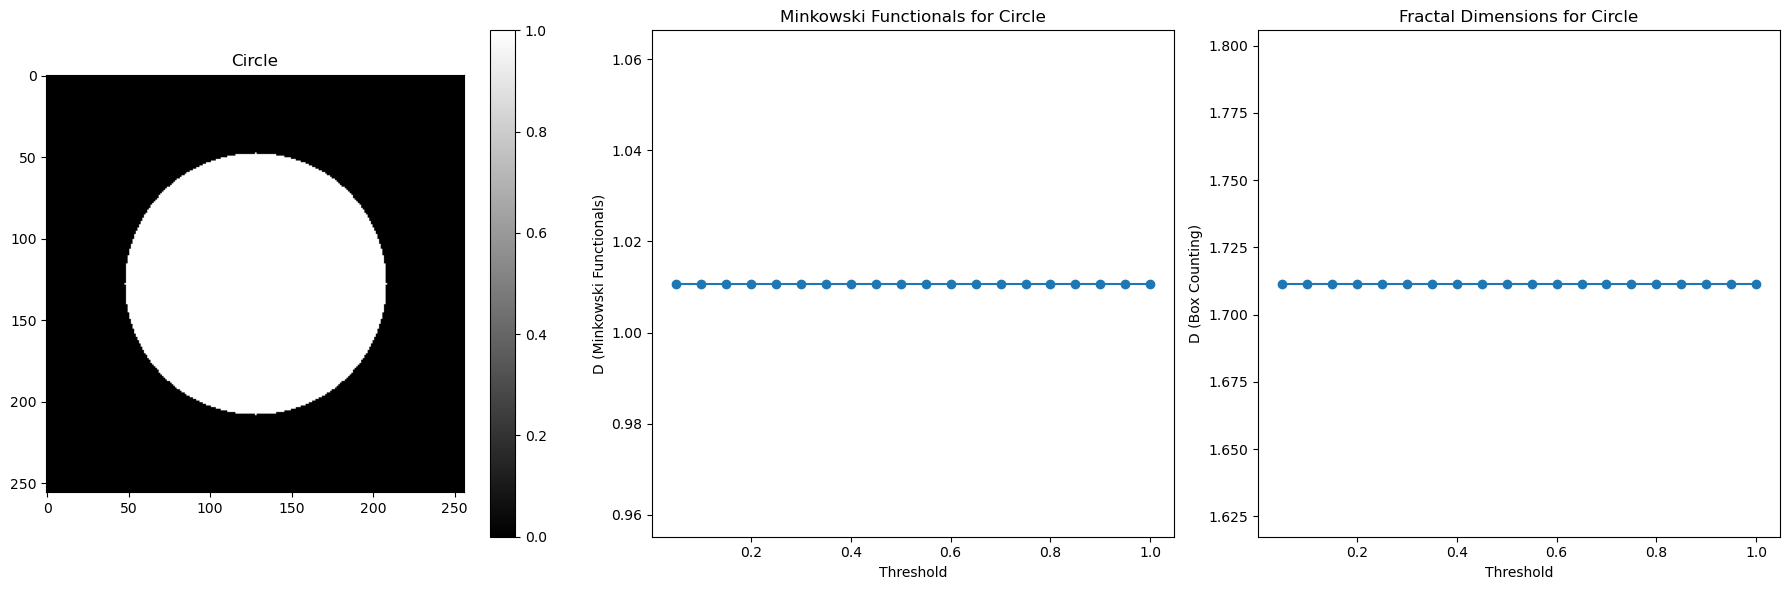

In [ ]:
# intercept corrected circle, but smaller to show that the BC method results in different values
# whereas the Minkowski functionals are the same (GOOD!!)

shape = (256, 256)

# Create a binary image with a circle
circle_image = np.zeros(shape, dtype=bool)
rr, cc = np.ogrid[:shape[0], :shape[1]]
circle_center = (shape[0] // 2, shape[1] // 2)
circle_radius = 80
circle_image[(rr - circle_center[0])**2 + (cc - circle_center[1])**2 <= circle_radius**2] = 1

# Display the circle image and its analyses in a (1, 3) subplot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(circle_image, cmap='gray')
plt.title('Circle')
plt.colorbar()

# Calculate Minkowski functionals for the circle image
circle_thresholds = np.linspace(0.05, 1, 20)
circle_results = circle_corrected_minkowski_functionals(circle_image.astype(float), thresholds=circle_thresholds)

plt.subplot(1, 3, 2)
plt.plot(circle_thresholds, ((circle_results["values"][3])), "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Minkowski Functionals)')
plt.title('Minkowski Functionals for Circle')

# Calculate fractal dimensions using box counting method
circle_fractal_dimensions = []
for threshold in circle_thresholds:
    circle_fractal_dimensions.append(box_counting_method(circle_image >= threshold))

plt.subplot(1, 3, 3)
plt.plot(circle_thresholds, circle_fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.title('Fractal Dimensions for Circle')

plt.tight_layout()
plt.show()

### **Which formula is to be used?**

The PA relation always shows an anti-correlation with the Box-Counting Method, yet both describe similar structural properties. The geometry of the object is also encoded in the proportionality constant $ k $. The next logical step was to determine a general formula incorporating $ k $ that could be applied universally. However, fitting for $ k $ consistently failed to return the expected values for known, simple structures. Only by providing an initial guess specifically tailored to each object was it possible to approximate the values derived earlier.

In practice, we want to avoid making geometric assumptions when analyzing molecular clouds. Even though we now have a better understanding of potential values for $ k $ and their implications for the method, fitting for $ k $ would impose an unwanted bias. Therefore, we should rely on the original formula:

$$ A \propto P^{D/2} $$

This approach ensures a more onsistent analysis of structures without assuming anything about the shape.

More tests are run in `Simulations_PA.ipynb`.

#### **Some of the attempts towards a General Formula accounting for the intercept**

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def minkowski_dimension_fit(areas, perimeters):
    """
    Fits the function P = k * A^(D/2) to estimate both D and k.
    
    Parameters:
        areas (array-like): List of area values.
        perimeters (array-like): Corresponding perimeter values.

    Returns:
        dict: Containing fitted values for D and k.
    """
    # Define the functional form P = k * A^(D/2)
    def model(A, D, k):
        return k*A**(D / 2)

    # Initial guess: D = 2 (Euclidean case), k = 1
    # Line
    initial_guess = [2, 1]
    
    # Plane
    initial_guess = [1, 3]

    # Circle
    initial_guess = [1, 3.5]
    
    # Fit the model
    params, covariance = curve_fit(model, areas, perimeters, p0=initial_guess)

    # Extract fitted parameters
    D_fitted, k_fitted = params

    return {"D": D_fitted, "k": k_fitted}

def intercept_corrected_minkowski_functionals(data, threshold_min=1e20, threshold_max=1e22, thresholds=None):
    if thresholds is None:
        thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Store Minkowski Functional values
    areas = []
    perimeters = []
    euler_chars = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1) with correction for the intercept
        perim = perimeter(mask)
        perimeters.append(perim)

        # Compute Euler Characteristic (v2)
        euler_char = euler_number(mask)
        euler_chars.append(euler_char)

    # Convert to log scale for fractal dimension analysis
    log_areas = np.log10(areas)
    log_perimeters = np.log10(perimeters)

    fit = minkowski_dimension_fit(areas, perimeters)
    D = fit["D"]
    print(D)
    intercept = fit["k"]

    D = 2 * (log_perimeters - np.log10(fit["k"])) / (log_areas)
    # D = 2 * (log_perimeters) / (log_areas + np.log10(fit["k"]))

    return {
        "thresholds": thresholds,
        "values": [areas, perimeters, euler_chars, D],
        "intercept": intercept
    }

# Test on: line, plane, circle

# Line
line_results = intercept_corrected_minkowski_functionals(line_image.astype(float), thresholds=line_thresholds)

# Plane
plane_results = intercept_corrected_minkowski_functionals(box_image.astype(float), thresholds=box_thresholds)

# Circle
circle_results = intercept_corrected_minkowski_functionals(circle_image.astype(float), thresholds=circle_thresholds)

# Plot
plt.figure(figsize=(18, 6))

# Line
plt.subplot(1, 3, 1)
plt.plot(line_thresholds, line_results["values"][3], "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Intercept Corrected)')
plt.title(f'Intercept Corrected Minkowski Functionals for Line (Should be 2) \nIntercept: {line_results["intercept"]:.2f}')

# Plane
plt.subplot(1, 3, 2)
plt.plot(box_thresholds, plane_results["values"][3], "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Intercept Corrected)')
plt.title(f'Intercept Corrected Minkowski Functionals for Plane (Should be 1) \nIntercept: {plane_results["intercept"]:.2f}')

# Circle
plt.subplot(1, 3, 3)
plt.plot(circle_thresholds, circle_results["values"][3], "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Intercept Corrected)')
plt.title(f'Intercept Corrected Minkowski Functionals for Circle (Should be 1) \nIntercept: {circle_results["intercept"]:.2f}')

plt.tight_layout()
plt.show()

## **(from here the needs to be reviewed and better organized, not up to date!)**
### **4: GRF**

C:\Users\User\AppData\Local\Temp\ipykernel_14932\3073492286.py:33: RuntimeWarning: divide by zero encountered in power
  power_spectrum = (k**a)
C:\Users\User\AppData\Local\Temp\ipykernel_14932\3073492286.py:39: RuntimeWarning: invalid value encountered in divide
  field_ft_CZ[:,:,0,0] = (kx * kx)/k**2 * field_ft
C:\Users\User\AppData\Local\Temp\ipykernel_14932\3073492286.py:40: RuntimeWarning: invalid value encountered in divide
  field_ft_CZ[:,:,0,1] = (kx * ky)/k**2 * field_ft
C:\Users\User\AppData\Local\Temp\ipykernel_14932\3073492286.py:42: RuntimeWarning: invalid value encountered in divide
  field_ft_CZ[:,:,1,1] = (ky * ky)/k**2 * field_ft


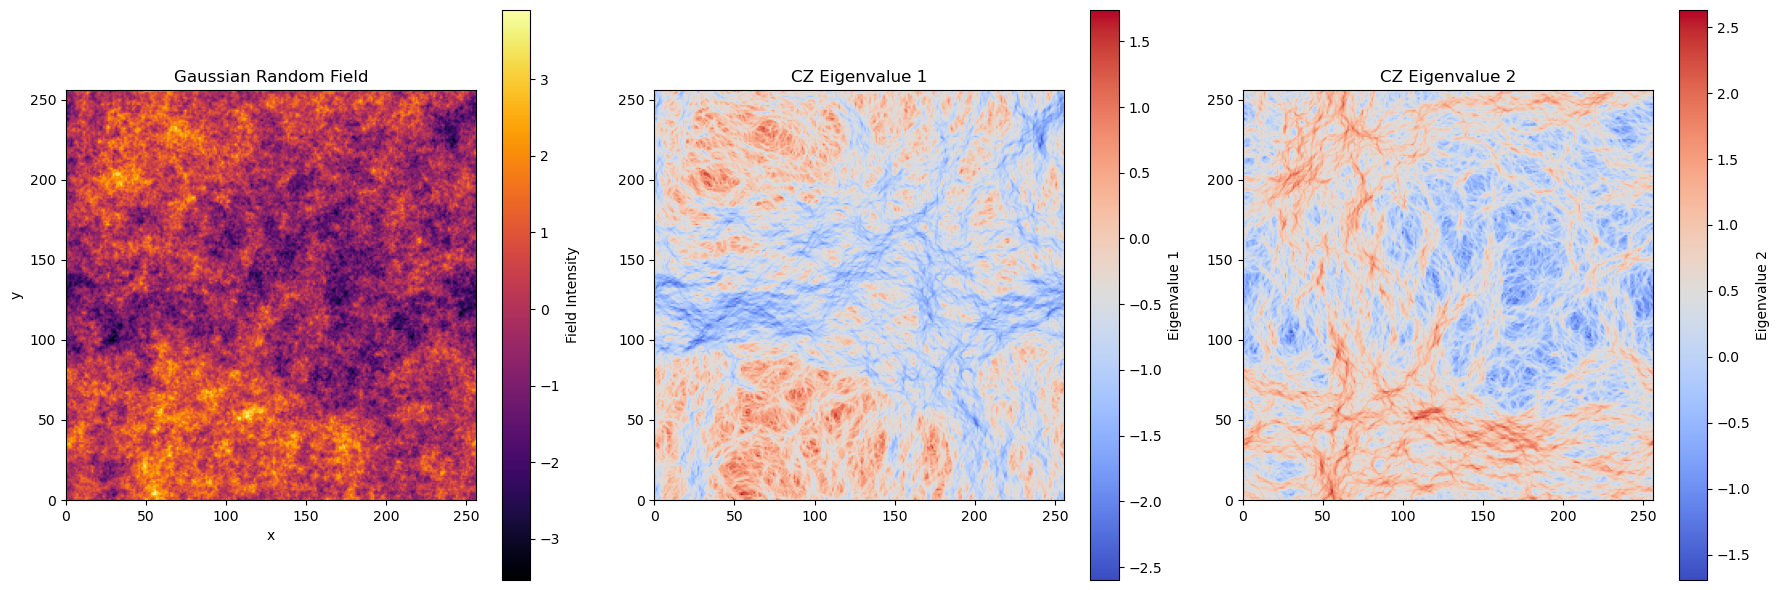

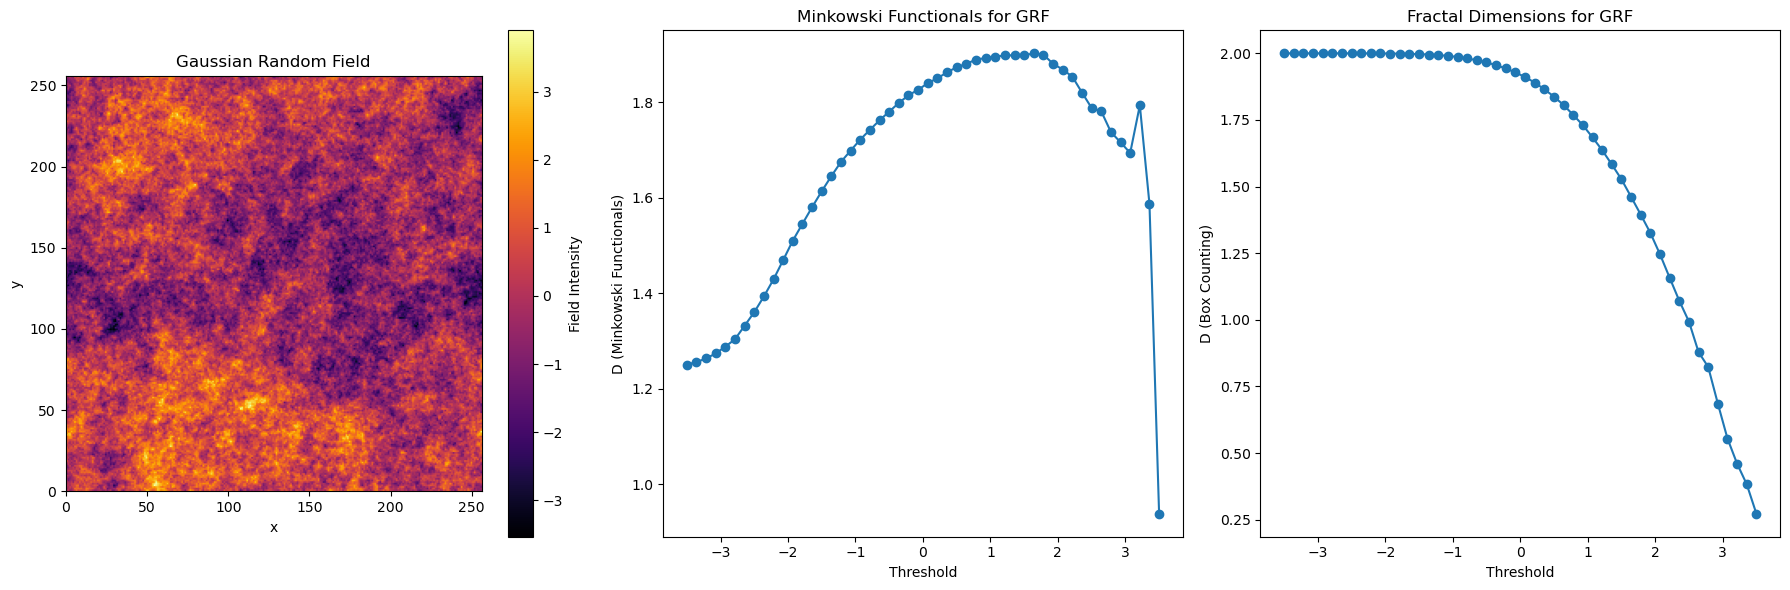

In [ ]:
### NOTE: Code from here is to be reviewed and improved!

import numpy as np
import matplotlib.pyplot as plt

## FUNCTION GENERATE A GAUSSIAN RANDOM FIELD

def generate_gaussian_random_field(size, a):
  """Generate a Gaussian random field with power law power spectrum.

  Args:
      size (int): the linear dimension of the field in pixels
      a (float): exponent of the power spectrum (P(k) ~ k^a)

  Returns:
      np.array: resulting scalar GRF of size (size, size)
      np.array: resulting eigenvalues of the CZ operator of size (size, size, 2)
  """
  # Create a grid of wave numbers
  kx = np.fft.fftfreq(size)
  ky = np.fft.fftfreq(size)
  kx, ky = np.meshgrid(kx, ky)
  k = np.sqrt(kx**2 + ky**2)

  # Generate random complex numbers with Gaussian distribution
  real_part = np.random.normal(size=(size, size))
  imag_part = np.random.normal(size=(size, size))
  random_field = real_part + 1j * imag_part

  # Apply the power spectrum
  power_spectrum = (k**a)
  power_spectrum[0, 0] = 0  # Avoid division by zero at the zero frequency
  field_ft = random_field * np.sqrt(power_spectrum)

  # apply the Caldéron-Zygmund operator
  field_ft_CZ = np.zeros((size, size,2,2), dtype=complex)
  field_ft_CZ[:,:,0,0] = (kx * kx)/k**2 * field_ft
  field_ft_CZ[:,:,0,1] = (kx * ky)/k**2 * field_ft
  field_ft_CZ[:,:,1,0] = field_ft_CZ[:,:,0,1]
  field_ft_CZ[:,:,1,1] = (ky * ky)/k**2 * field_ft

  field_ft_CZ[0,0,:,:] = 0
  # inverse Fourier transform
  field_CZ = np.fft.ifft2(field_ft_CZ,axes=(0,1)).real
  # compute eigenvalues
  field_CZ_eval = np.linalg.eigvalsh(field_CZ)

  # Perform the inverse FFT to get the spatial field
  field = np.fft.ifft2(field_ft).real

  norm = 1 / field.flatten().std()

  return field * norm, field_CZ_eval * norm

# Define parameters
size = 256   # Size of the grid (256x256)
a = -2.0     # Power spectrum exponent

# Generate the Gaussian random field
field, field_CZ_eval = generate_gaussian_random_field(size, a)

#
# Display the GRF and its analyses in a (1, 3) subplot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(field, cmap='inferno', origin='lower', extent=[0, size, 0, size])
plt.colorbar(label="Field Intensity")
plt.title("Gaussian Random Field")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1, 3, 2)
plt.imshow(field_CZ_eval[:, :, 0], cmap='coolwarm', origin='lower', extent=[0, size, 0, size])
plt.colorbar(label="Eigenvalue 1")
plt.title("CZ Eigenvalue 1")

plt.subplot(1, 3, 3)
plt.imshow(field_CZ_eval[:, :, 1], cmap='coolwarm', origin='lower', extent=[0, size, 0, size])
plt.colorbar(label="Eigenvalue 2")
plt.title("CZ Eigenvalue 2")

plt.tight_layout()
plt.show()

# Display the circle image and its analyses in a (1, 3) subplot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(field, cmap='inferno', origin='lower', extent=[0, size, 0, size])
plt.colorbar(label="Field Intensity")
plt.title("Gaussian Random Field")
plt.xlabel("x")
plt.ylabel("y")

# Calculate Minkowski functionals for the circle image
GRF_thresholds = np.linspace(-3.5, 3.5, 50)
GRF_results = standard_minkowski_functionals(field.astype(float), thresholds=GRF_thresholds)

plt.subplot(1, 3, 2)
plt.plot(GRF_thresholds, ((GRF_results["values"][3])), "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Minkowski Functionals)')
plt.title('Minkowski Functionals for GRF')

# Calculate fractal dimensions using box counting method
GRF_fractal_dimensions = []
for threshold in GRF_thresholds:
    GRF_fractal_dimensions.append(box_counting_method(field >= threshold))

plt.subplot(1, 3, 3)
plt.plot(GRF_thresholds, GRF_fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.title('Fractal Dimensions for GRF')

plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_3924\2335474859.py:29: RuntimeWarning: divide by zero encountered in power
  power_spectrum = (k**a)
C:\Users\User\AppData\Local\Temp\ipykernel_3924\2335474859.py:35: RuntimeWarning: invalid value encountered in divide
  field_ft_CZ[:,:,0,0] = (kx * kx)/k**2 * field_ft
C:\Users\User\AppData\Local\Temp\ipykernel_3924\2335474859.py:36: RuntimeWarning: invalid value encountered in divide
  field_ft_CZ[:,:,0,1] = (kx * ky)/k**2 * field_ft
C:\Users\User\AppData\Local\Temp\ipykernel_3924\2335474859.py:38: RuntimeWarning: invalid value encountered in divide
  field_ft_CZ[:,:,1,1] = (ky * ky)/k**2 * field_ft


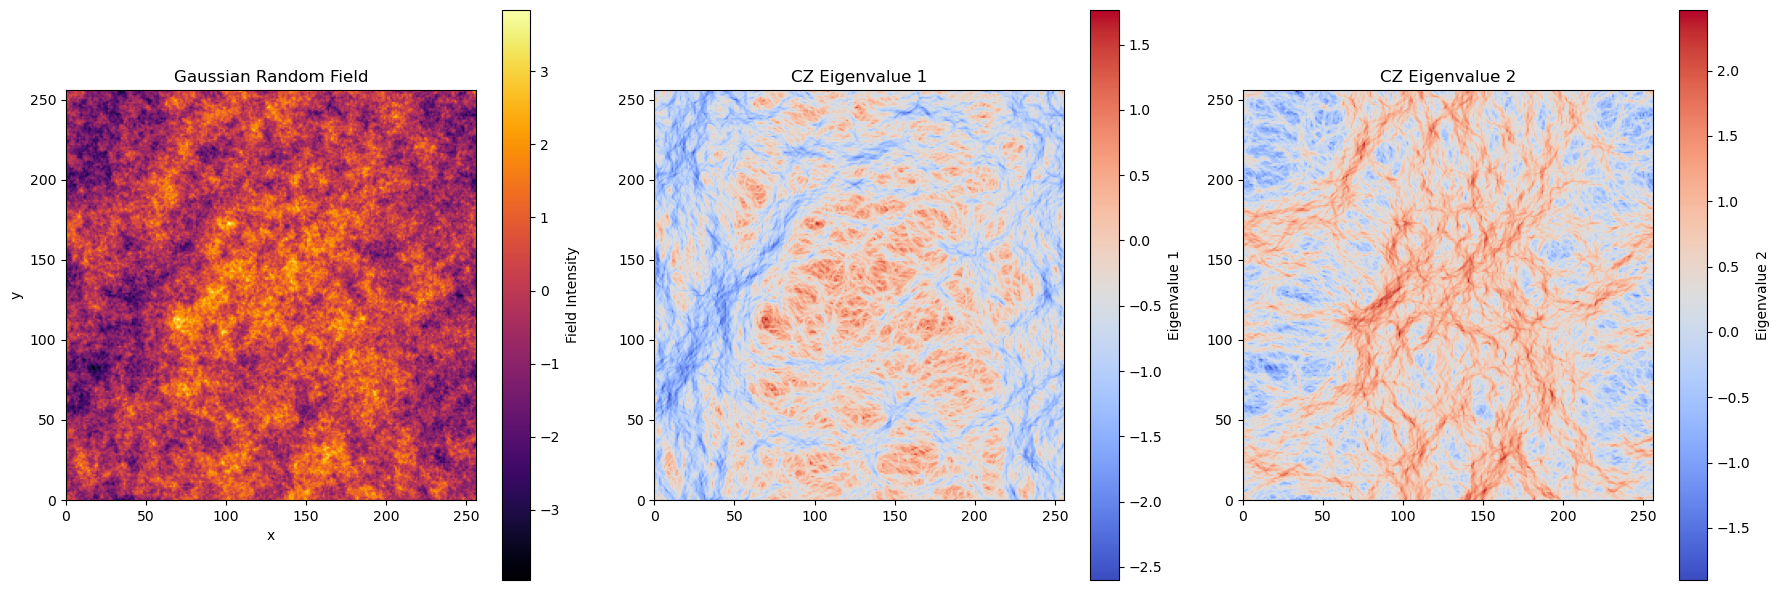

In [118]:
import numpy as np
import matplotlib.pyplot as plt

## FUNCTION GENERATE A GAUSSIAN RANDOM FIELD

def generate_gaussian_random_field(size, a):
  """Generate a Gaussian random field with power law power spectrum.

  Args:
      size (int): the linear dimension of the field in pixels
      a (float): exponent of the power spectrum (P(k) ~ k^a)

  Returns:
      np.array: resulting scalar GRF of size (size, size)
      np.array: resulting eigenvalues of the CZ operator of size (size, size, 2)
  """
  # Create a grid of wave numbers
  kx = np.fft.fftfreq(size)
  ky = np.fft.fftfreq(size)
  kx, ky = np.meshgrid(kx, ky)
  k = np.sqrt(kx**2 + ky**2)

  # Generate random complex numbers with Gaussian distribution
  real_part = np.random.normal(size=(size, size))
  imag_part = np.random.normal(size=(size, size))
  random_field = real_part + 1j * imag_part

  # Apply the power spectrum
  power_spectrum = (k**a)
  power_spectrum[0, 0] = 0  # Avoid division by zero at the zero frequency
  field_ft = random_field * np.sqrt(power_spectrum)

  # apply the Caldéron-Zygmund operator
  field_ft_CZ = np.zeros((size, size,2,2), dtype=complex)
  field_ft_CZ[:,:,0,0] = (kx * kx)/k**2 * field_ft
  field_ft_CZ[:,:,0,1] = (kx * ky)/k**2 * field_ft
  field_ft_CZ[:,:,1,0] = field_ft_CZ[:,:,0,1]
  field_ft_CZ[:,:,1,1] = (ky * ky)/k**2 * field_ft

  field_ft_CZ[0,0,:,:] = 0
  # inverse Fourier transform
  field_CZ = np.fft.ifft2(field_ft_CZ,axes=(0,1)).real
  # compute eigenvalues
  field_CZ_eval = np.linalg.eigvalsh(field_CZ)

  # Perform the inverse FFT to get the spatial field
  field = np.fft.ifft2(field_ft).real

  norm = 1 / field.flatten().std()

  return field * norm, field_CZ_eval * norm

# Define parameters
size = 256   # Size of the grid (256x256)
a = -2.0     # Power spectrum exponent

# Generate the Gaussian random field
field, field_CZ_eval = generate_gaussian_random_field(size, a)

#
# Display the GRF and its analyses in a (1, 3) subplot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(field, cmap='inferno', origin='lower', extent=[0, size, 0, size])
plt.colorbar(label="Field Intensity")
plt.title("Gaussian Random Field")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1, 3, 2)
plt.imshow(field_CZ_eval[:, :, 0], cmap='coolwarm', origin='lower', extent=[0, size, 0, size])
plt.colorbar(label="Eigenvalue 1")
plt.title("CZ Eigenvalue 1")

plt.subplot(1, 3, 3)
plt.imshow(field_CZ_eval[:, :, 1], cmap='coolwarm', origin='lower', extent=[0, size, 0, size])
plt.colorbar(label="Eigenvalue 2")
plt.title("CZ Eigenvalue 2")

plt.tight_layout()
plt.show()


# 4: A Gaussian

C:\Users\User\AppData\Local\Temp\ipykernel_3924\1071278765.py:30: RuntimeWarning: divide by zero encountered in log10
  log_perimeters = np.log10(perimeters)


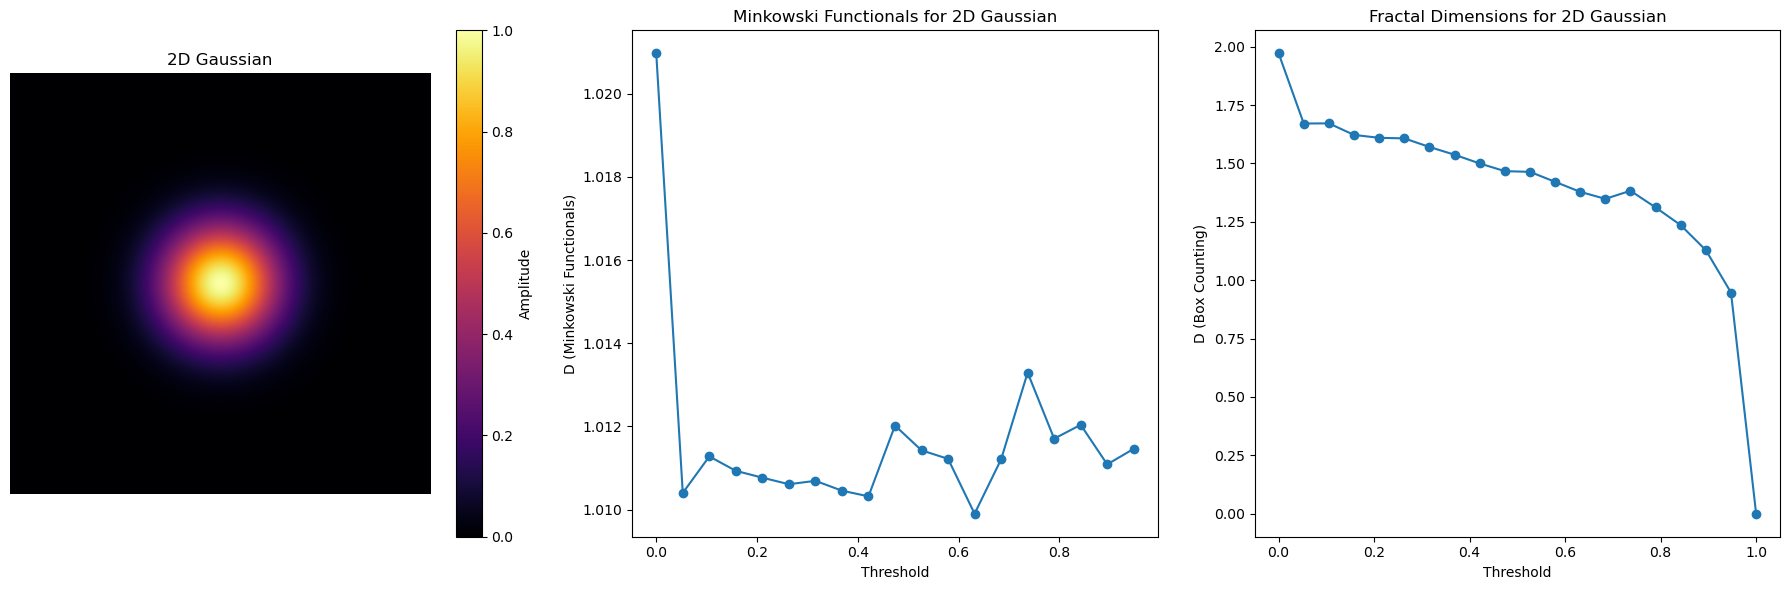

In [117]:
# Function to generate a Gaussian with potential cut-offs
def generate_2d_gaussian(shape, center, sigma):
    """
    Generate a Gaussian distribution that may cut off at the edges of the data.
    
    Parameters:
    - shape: Tuple (nx, ny), the size of the 2D grid.
    - center: Tuple (x0, y0), the center of the Gaussian.
    - sigma: Standard deviation of the Gaussian.
    
    Returns:
    - gaussian: 2D array with the Gaussian distribution.
    """
    x = np.arange(0, shape[0])
    y = np.arange(0, shape[1])
    xx, yy = np.meshgrid(x, y)
    
    gaussian = np.exp(-(((xx - center[0])**2 + (yy - center[1])**2) / (2 * sigma**2)))
    return gaussian

# Generate a single 2D Gaussian
shape = (512, 512)
center = (256, 256)  # Center of the Gaussian
sigma = 50  # Standard deviation of the Gaussian
gaussian = generate_2d_gaussian(shape, center, sigma)

# Display the Gaussian and its analyses in a (1, 3) subplot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(gaussian, origin='lower', cmap='inferno', extent=[0, shape[0], 0, shape[1]])
plt.colorbar(label="Amplitude")
plt.title("2D Gaussian")
plt.axis("off")

# Calculate Minkowski functionals for the Gaussian
gaussian_thresholds = np.linspace(np.min(gaussian), np.max(gaussian), 20)
gaussian_results = circle_corrected_minkowski_functionals(gaussian, thresholds=gaussian_thresholds)

plt.subplot(1, 3, 2)
plt.plot(gaussian_thresholds, gaussian_results["values"][3], "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Minkowski Functionals)')
plt.title('Minkowski Functionals for 2D Gaussian')

# Calculate fractal dimensions using box counting method
gaussian_fractal_dimensions = []
for threshold in gaussian_thresholds:
    gaussian_fractal_dimensions.append(box_counting_method(gaussian >= threshold))

plt.subplot(1, 3, 3)
plt.plot(gaussian_thresholds, gaussian_fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')
plt.title('Fractal Dimensions for 2D Gaussian')

plt.tight_layout()
plt.show()

## Cut-Off Effects

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
C:\Users\User\AppData\Local\Temp\ipykernel_3924\3330922000.py:32: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"Gaussian {i+1}, $\sigma={sigmas[i]}$")


Analyzing Gaussian 1 with sigma=15
Analyzing Gaussian 2 with sigma=30
Analyzing Gaussian 3 with sigma=60
Analyzing Gaussian 4 with sigma=150
Analyzing Gaussian 5 with sigma=300


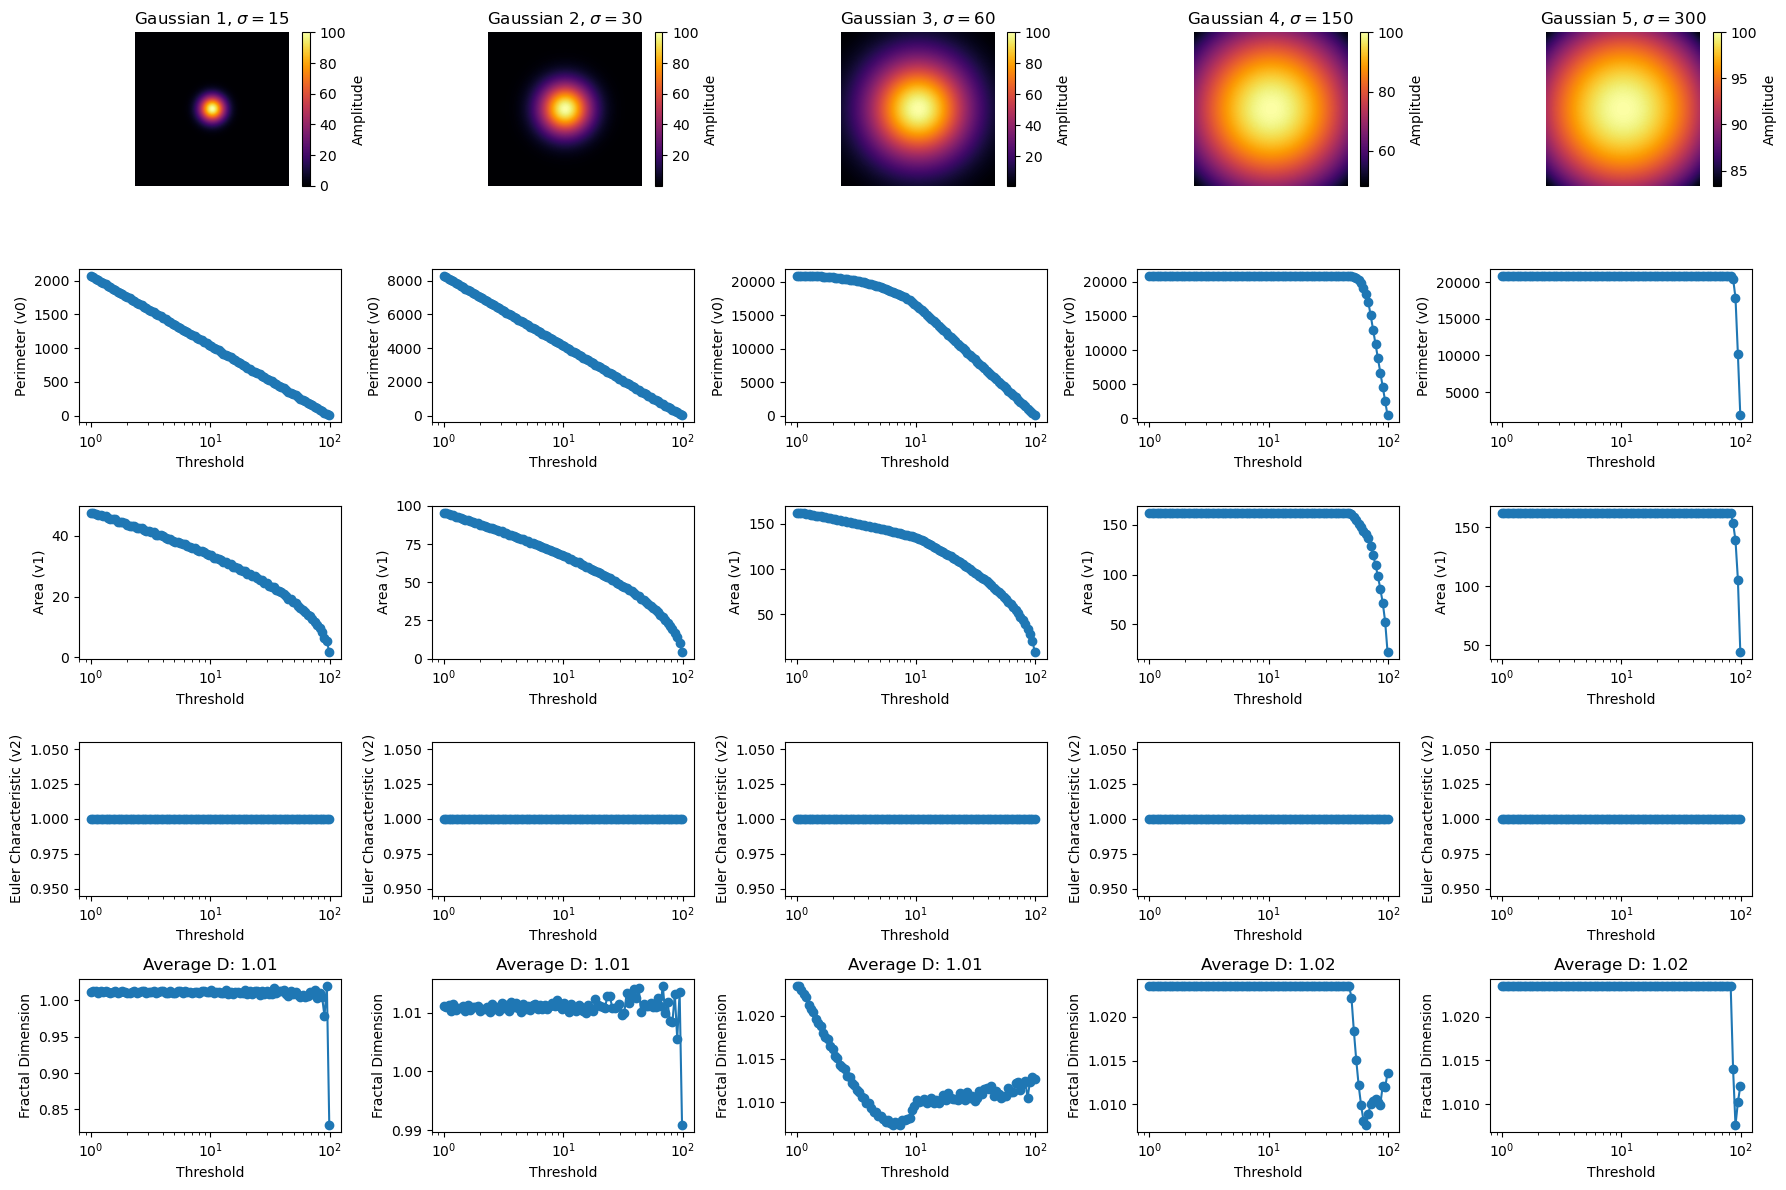

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from skimage.measure import perimeter


# Parameters for the Gaussian
shape = (256, 256)
centers = [(128, 128), (128, 128), (128, 128), (128, 128), (128, 128)]  # Center of Gaussian
sigmas = [15, 30, 60, 150, 300]  # Standard deviations, increasing size

# Generate Gaussian distributions
gaussians = [100*generate_2d_gaussian(shape, centers[i], sigmas[i]) for i in range(len(sigmas))]

# Analyze each Gaussian using the Minkowski function
results = []

# Visualize all Gaussians and their Minkowski functional results
plt.figure(figsize=(18, 12))
    
# Analyze each Gaussian
results = []
for i, gaussian in enumerate(gaussians):
    print(f"Analyzing Gaussian {i+1} with sigma={sigmas[i]}")
    result = circle_corrected_minkowski_functionals(gaussian, threshold_min=1, threshold_max=99)
    results.append(result)

# First row: Gaussian images
for i, gaussian in enumerate(gaussians):
    plt.subplot(5, len(gaussians), i + 1)
    plt.imshow(gaussian, origin='lower', cmap='inferno', extent=[0, shape[0], 0, shape[1]])
    plt.title(f"Gaussian {i+1}, $\sigma={sigmas[i]}$")
    plt.colorbar(label="Amplitude")
    plt.axis("off")

# Second, third, fourth rows: Minkowski functionals
labels = ["Perimeter (v0)", "Area (v1)", "Euler Characteristic (v2)", "Fractal Dimension"]
for j in range(4):  # One row for each functional
    for i, gaussian in enumerate(gaussians):
        plt.subplot(5, len(gaussians), (j + 1) * len(gaussians) + i + 1)
        plt.plot(results[i]["thresholds"], results[i]["values"][j], 'o-')
        plt.xlabel("Threshold")
        plt.ylabel(labels[j])
        plt.xscale("log")
        if j == 3:  # For the fractal dimension row
            avg_fractal_dim = np.nanmean(results[i]["values"][j]) 
            plt.title(f"Average D: {avg_fractal_dim:.2f}")
            
plt.tight_layout()
plt.show()

## Small Scales

<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\s'
C:\Users\User\AppData\Local\Temp\ipykernel_3924\1400089730.py:51: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"Gaussian {i+1}, $\sigma={sigmas[i]}$")


Analyzing Gaussian 1 with sigma=15
Analyzing Gaussian 2 with sigma=12
Analyzing Gaussian 3 with sigma=10
Analyzing Gaussian 4 with sigma=8
Analyzing Gaussian 5 with sigma=5


C:\Users\User\AppData\Local\Temp\ipykernel_3924\1071278765.py:30: RuntimeWarning: divide by zero encountered in log10
  log_perimeters = np.log10(perimeters)


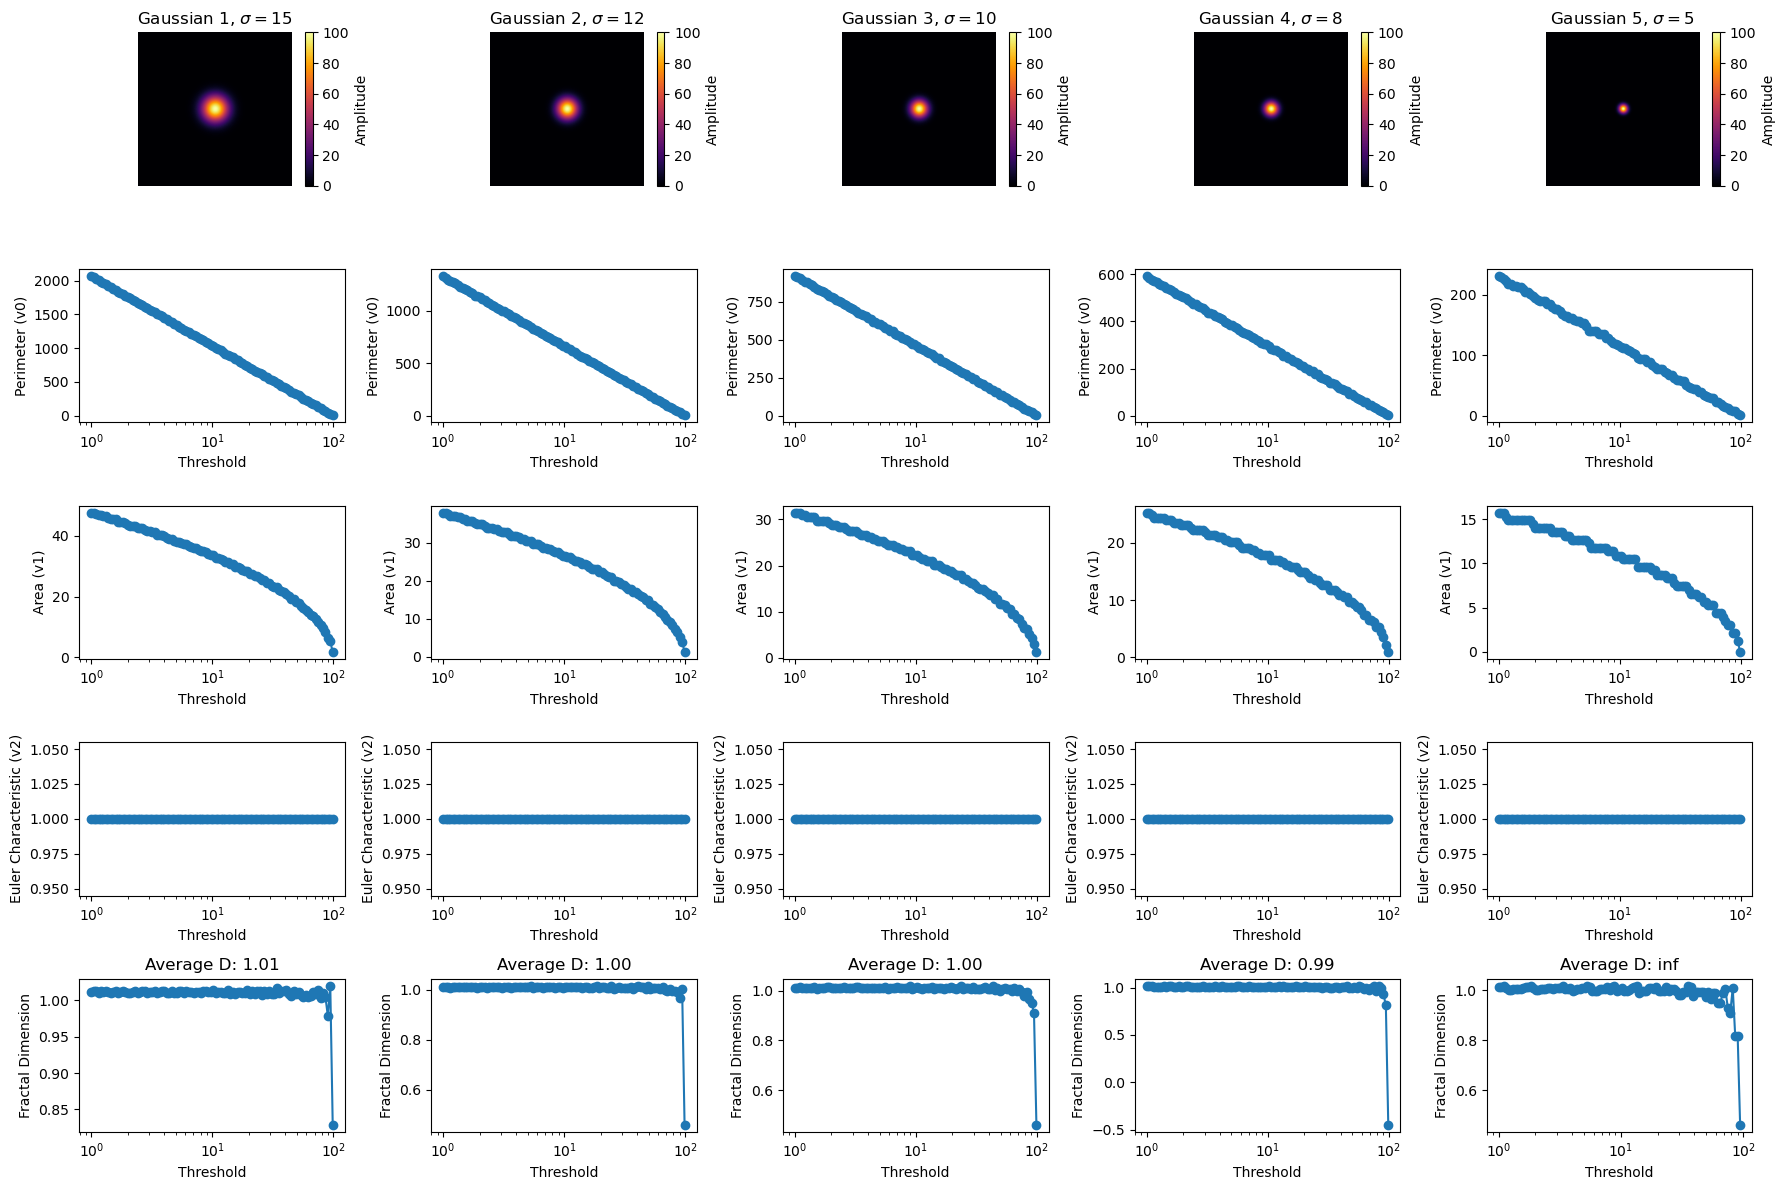

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from skimage.measure import perimeter

# Function to generate a Gaussian with potential cut-offs
def generate_2d_gaussian(shape, center, sigma):
    """
    Generate a Gaussian distribution that may cut off at the edges of the data.
    
    Parameters:
    - shape: Tuple (nx, ny), the size of the 2D grid.
    - center: Tuple (x0, y0), the center of the Gaussian.
    - sigma: Standard deviation of the Gaussian.
    
    Returns:
    - gaussian: 2D array with the Gaussian distribution.
    """
    x = np.arange(0, shape[0])
    y = np.arange(0, shape[1])
    xx, yy = np.meshgrid(x, y)
    
    gaussian = np.exp(-(((xx - center[0])**2 + (yy - center[1])**2) / (2 * sigma**2)))
    return gaussian

# Parameters for the Gaussian
shape = (256, 256)
centers = [(128, 128), (128, 128), (128, 128), (128, 128), (128, 128)]  # Center of Gaussian
sigmas = [15, 12, 10, 8, 5]  # Standard deviations, increasing size

# Generate Gaussian distributions
gaussians = [100*generate_2d_gaussian(shape, centers[i], sigmas[i]) for i in range(len(sigmas))]

# Analyze each Gaussian using the Minkowski function
results = []

# Visualize all Gaussians and their Minkowski functional results
plt.figure(figsize=(18, 12))
    
# Analyze each Gaussian
results = []
for i, gaussian in enumerate(gaussians):
    print(f"Analyzing Gaussian {i+1} with sigma={sigmas[i]}")
    result = circle_corrected_minkowski_functionals(gaussian, threshold_min=1, threshold_max=99)
    results.append(result)

# First row: Gaussian images
for i, gaussian in enumerate(gaussians):
    plt.subplot(5, len(gaussians), i + 1)
    plt.imshow(gaussian, origin='lower', cmap='inferno', extent=[0, shape[0], 0, shape[1]])
    plt.title(f"Gaussian {i+1}, $\sigma={sigmas[i]}$")
    plt.colorbar(label="Amplitude")
    plt.axis("off")

# Second, third, fourth rows: Minkowski functionals
labels = ["Perimeter (v0)", "Area (v1)", "Euler Characteristic (v2)", "Fractal Dimension"]

for j in range(4):  # One row for each functional
    for i, gaussian in enumerate(gaussians):
        plt.subplot(5, len(gaussians), (j + 1) * len(gaussians) + i + 1)
        plt.plot(results[i]["thresholds"], results[i]["values"][j], 'o-')
        plt.xlabel("Threshold")
        plt.ylabel(labels[j])
        plt.xscale("log")
        if j == 3:  # For the fractal dimension row
            avg_fractal_dim = np.nanmean(results[i]["values"][j]) 
            plt.title(f"Average D: {avg_fractal_dim:.2f}")
            
plt.tight_layout()
plt.show()

## Inspecting a Gaussian at different thresholds

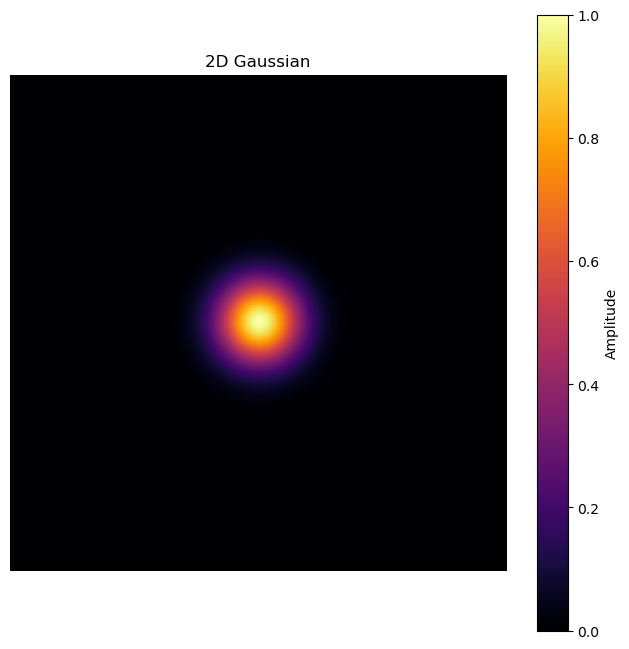

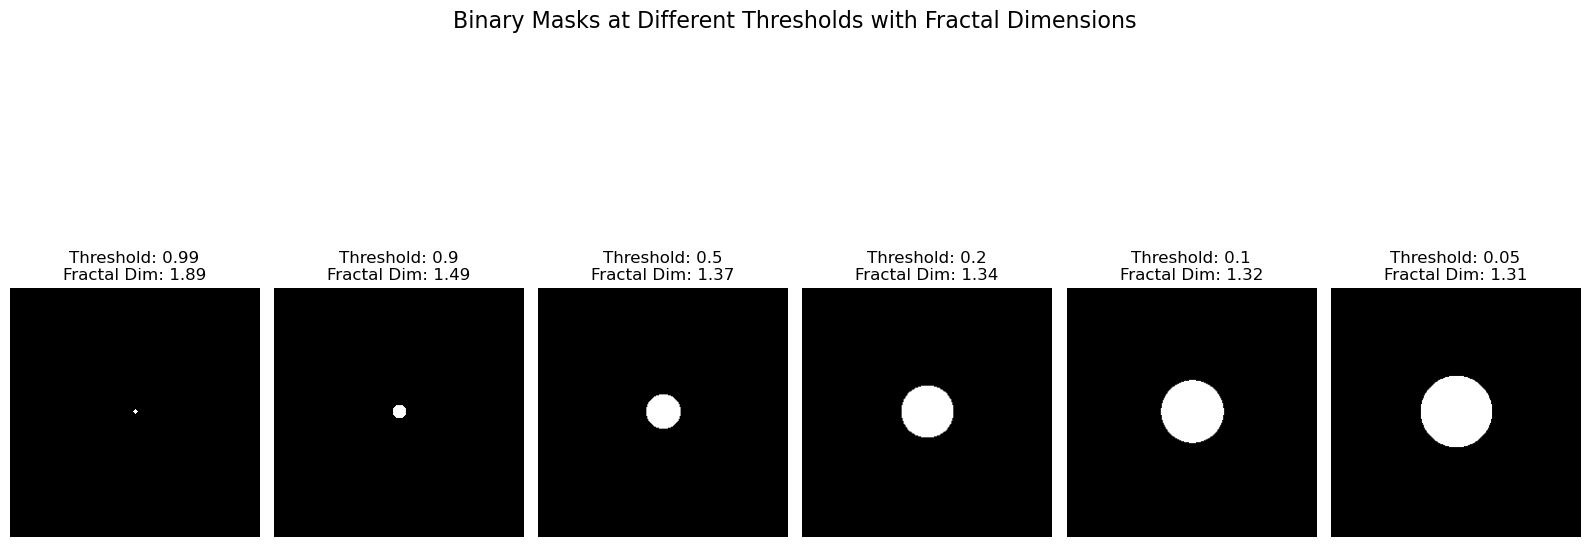

Threshold: 0.99, Fractal Dimension: 1.89
Threshold: 0.9, Fractal Dimension: 1.49
Threshold: 0.5, Fractal Dimension: 1.37
Threshold: 0.2, Fractal Dimension: 1.34
Threshold: 0.1, Fractal Dimension: 1.32
Threshold: 0.05, Fractal Dimension: 1.31


In [4]:
# Generate a single 2D Gaussian
shape = (256, 256)
center = (128, 128)  # Center of the Gaussian
sigma = 15  # Standard deviation of the Gaussian
gaussian = generate_2d_gaussian(shape, center, sigma)

# Visualize the Gaussian
plt.figure(figsize=(8, 8))
plt.imshow(gaussian, origin='lower', cmap='inferno', extent=[0, shape[0], 0, shape[1]])
plt.colorbar(label="Amplitude")
plt.title("2D Gaussian")
plt.axis("off")
plt.show()

# Thresholds for visualization
thresholds = [0.99, 0.9, 0.5, 0.2, 0.1, 0.05]  # Example thresholds
fractal_dimensions = []  # To store fractal dimensions

# Calculate fractal dimensions and plot binary masks
plt.figure(figsize=(16, 8))

for i, threshold in enumerate(thresholds):
    # Create binary mask
    mask = gaussian >= threshold
    
    # Compute Minkowski functionals for the mask
    area = np.sum(mask)
    perim = perimeter(mask)
    if area > 0 and perim > 0:  # Avoid invalid fractal dimension
        fractal_dimension = 2 * np.log10(perim) / np.log10(area)
    else:
        fractal_dimension = np.nan  # Assign NaN if invalid
    fractal_dimensions.append(fractal_dimension)

    # Plot the binary mask
    plt.subplot(1, len(thresholds), i + 1)
    plt.imshow(mask, origin='lower', cmap='gray', extent=[0, shape[0], 0, shape[1]])
    plt.title(f"Threshold: {threshold}\nFractal Dim: {fractal_dimension:.2f}")
    plt.axis("off")

plt.suptitle("Binary Masks at Different Thresholds with Fractal Dimensions", fontsize=16)
plt.tight_layout()
plt.show()

# Print fractal dimensions for reference
for t, fd in zip(thresholds, fractal_dimensions):
    print(f"Threshold: {t}, Fractal Dimension: {fd:.2f}")


# Filaments

Analyzing Filament 1 with XX 
Analyzing Filament 2 with XX 
Analyzing Filament 3 with XX 
Analyzing Filament 4 with XX 
Analyzing Filament 5 with XX 


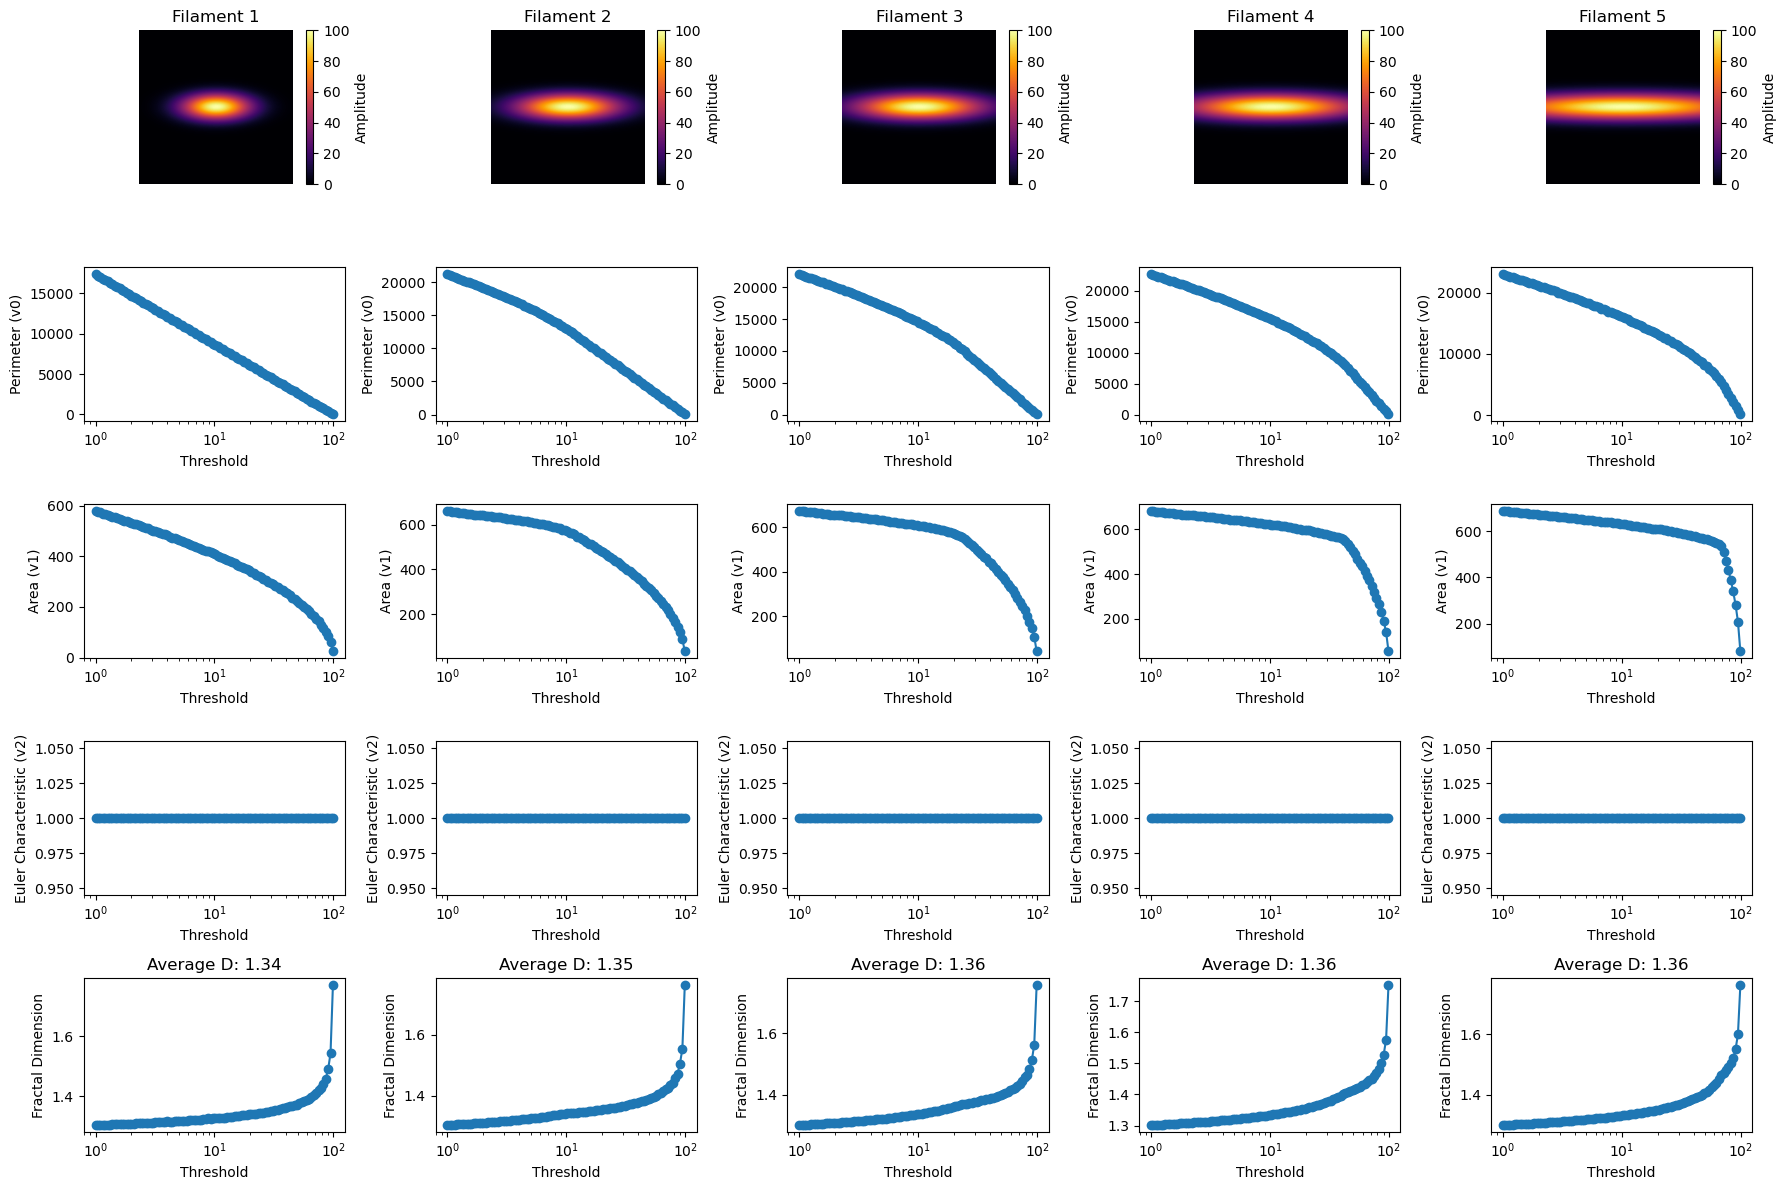

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def generate_filament(shape, center, length, width, angle):
    """
    Generate a single filamentary (cylindrical) structure in 2D.

    Parameters:
    - shape: Tuple (nx, ny), the size of the 2D grid.
    - center: Tuple (x0, y0), the center of the filament.
    - length: Length of the filament.
    - width: Width (standard deviation) of the filament.
    - angle: Angle of the filament in degrees (0 = horizontal).

    Returns:
    - filament: 2D array containing the filamentary structure.
    """
    x = np.arange(0, shape[0])
    y = np.arange(0, shape[1])
    xx, yy = np.meshgrid(x, y)

    # Rotate the grid to align the filament with the given angle
    x_rot = (xx - center[0]) * np.cos(np.radians(angle)) + (yy - center[1]) * np.sin(np.radians(angle))
    y_rot = -(xx - center[0]) * np.sin(np.radians(angle)) + (yy - center[1]) * np.cos(np.radians(angle))

    # Create the filament as a Gaussian along the rotated x-axis
    filament = np.exp(-((x_rot**2) / (2 * (length / 2)**2) + (y_rot**2) / (2 * (width / 2)**2)))
    return filament

# Parameters for the Gaussian
shape = (256, 256) # Size of the grid
centers = [(128, 128), (128, 128), (128, 128), (128, 128), (128, 128)]  # Center of the filament

lengths = [80, 120, 150, 200, 300]  # Length of the filament
widths = [30, 30, 30, 30, 30]  # Width of the filament
angles = [0, 0, 0, 0, 0]  # Angle in degrees (e.g., 30°)

# Generate Gaussian distributions
filaments = [100*generate_filament(shape, centers[i], lengths[i], widths[i], angles[i]) for i in range(len(centers))]

# Analyze each Gaussian using the Minkowski function
results = []

# Visualize all Gaussians and their Minkowski functional results
plt.figure(figsize=(18, 12))
    
# Analyze each Gaussian
results = []
for i, filament in enumerate(filaments):
    print(f"Analyzing Filament {i+1} with XX ")
    result = minkowski_funct(filament, region_name=f"Gaussian {i+1}", threshold_min=1, threshold_max=99)
    results.append(result)

# First row: Gaussian images
for i, filament in enumerate(filaments):
    plt.subplot(5, len(filaments), i + 1)
    plt.imshow(filament, origin='lower', cmap='inferno', extent=[0, shape[0], 0, shape[1]])
    plt.title(f"Filament {i+1}")
    plt.colorbar(label="Amplitude")
    plt.axis("off")

# Second, third, fourth rows: Minkowski functionals
labels = ["Perimeter (v0)", "Area (v1)", "Euler Characteristic (v2)", "Fractal Dimension"]

for j in range(4):  # One row for each functional
    for i, filament in enumerate(filaments):
        plt.subplot(5, len(filaments), (j + 1) * len(filaments) + i + 1)
        plt.plot(results[i]["thresholds"], results[i]["values"][j], 'o-')
        plt.xlabel("Threshold")
        plt.ylabel(labels[j])
        plt.xscale("log")
        if j == 3:  # For the fractal dimension row
            avg_fractal_dim = np.nanmean(results[i]["values"][j]) 
            plt.title(f"Average D: {avg_fractal_dim:.2f}")
            
plt.tight_layout()
plt.show()

# Combination

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate a Gaussian with random center and size
def generate_random_gaussian(shape, max_sigma):
    """
    Generate a random Gaussian with random center and size.
    Parameters:
    - shape: Tuple (nx, ny), the size of the 2D grid.
    - max_sigma: Maximum standard deviation for Gaussian size.
    Returns:
    - gaussian: 2D array with the Gaussian distribution.
    """
    center = (np.random.randint(0, shape[0]), np.random.randint(0, shape[1]))
    sigma = np.random.uniform(5, max_sigma)  # Random standard deviation
    x = np.arange(0, shape[0])
    y = np.arange(0, shape[1])
    xx, yy = np.meshgrid(x, y)
    gaussian = np.exp(-(((xx - center[0])**2 + (yy - center[1])**2) / (2 * sigma**2)))
    return gaussian

# Function to generate a filament with random center, size, and orientation
def generate_random_filament(shape, max_length, max_width):
    """
    Generate a random filamentary object with random center, size, and angle.
    Parameters:
    - shape: Tuple (nx, ny), the size of the 2D grid.
    - max_length: Maximum length of the filament.
    - max_width: Maximum width of the filament.
    Returns:
    - filament: 2D array with the filamentary structure.
    """
    center = (np.random.randint(0, shape[0]), np.random.randint(0, shape[1]))
    length = np.random.uniform(30, max_length)  # Random length
    width = np.random.uniform(6, max_width)    # Random width
    angle = np.random.uniform(0, 180)          # Random orientation
    x = np.arange(0, shape[0])
    y = np.arange(0, shape[1])
    xx, yy = np.meshgrid(x, y)
    x_rot = (xx - center[0]) * np.cos(np.radians(angle)) + (yy - center[1]) * np.sin(np.radians(angle))
    y_rot = -(xx - center[0]) * np.sin(np.radians(angle)) + (yy - center[1]) * np.cos(np.radians(angle))
    filament = np.exp(-((x_rot**2) / (2 * (length / 2)**2) + (y_rot**2) / (2 * (width / 2)**2)))
    return filament

# Function to create a mixed field with Gaussians and filaments
def create_mixed_field(shape, num_objects, max_sigma, max_length, max_width, mix_ratio=1):
    """
    Create a field with a mix of Gaussian and filamentary objects.
    Parameters:
    - shape: Size of the 2D grid (nx, ny).
    - num_objects: Total number of objects to place.
    - max_sigma: Maximum size for Gaussians.
    - max_length, max_width: Maximum size for filaments.
    - mix_ratio: Proportion of Gaussians (0.5 = equal mix).
    Returns:
    - field: 2D array with the mixed field.
    """
    field = np.zeros(shape)
    num_gaussians = int(num_objects * mix_ratio)
    num_filaments = num_objects - num_gaussians

    # Add Gaussians
    for _ in range(num_gaussians):
        field += generate_random_gaussian(shape, max_sigma)

    # Add Filaments
    for _ in range(num_filaments):
        field += generate_random_filament(shape, max_length, max_width)

    return field

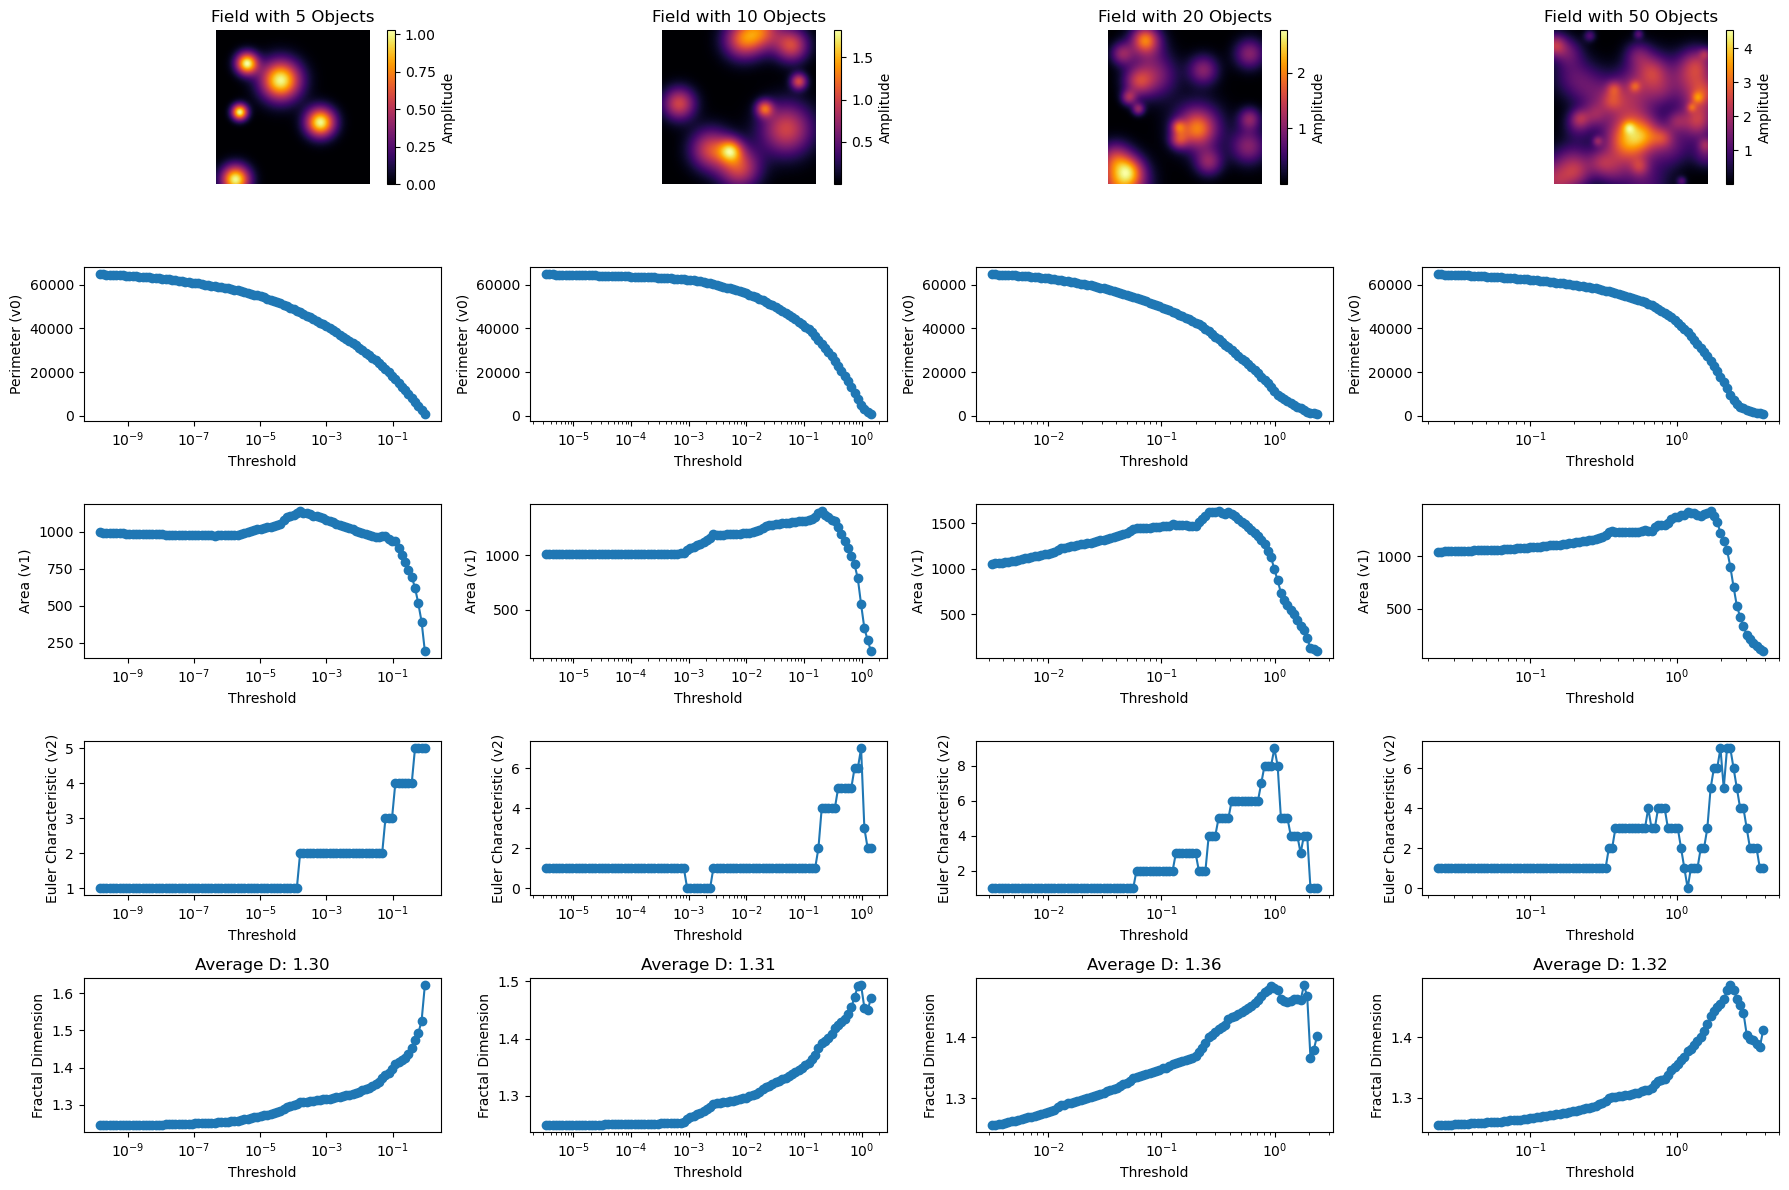

In [12]:
# Simulation parameters, only Gaussians
shape = (256, 256)
max_sigma = 30
max_length = 100
max_width = 20
object_densities = [5, 10, 20, 50]
mix_ratio = 1

# Generate and analyze fields
fields = []
results = []
for num_objects in object_densities:
    field = create_mixed_field(shape, num_objects, max_sigma, max_length, max_width, mix_ratio)
    fields.append(field)
    results.append(minkowski_funct(field, threshold_min=np.percentile(field, 1), threshold_max=np.percentile(field, 99)))

# Visualize all Gaussians and their Minkowski functional results
plt.figure(figsize=(18, 12))

# First row: Gaussian images
for i, field in enumerate(fields):
    plt.subplot(5, len(fields), i + 1)
    plt.imshow(field, origin='lower', cmap='inferno', extent=[0, shape[0], 0, shape[1]])
    plt.title(f"Field with {object_densities[i]} Objects")
    plt.colorbar(label="Amplitude")
    plt.axis("off")

# Second, third, fourth rows: Minkowski functionals
labels = ["Perimeter (v0)", "Area (v1)", "Euler Characteristic (v2)", "Fractal Dimension"]

for j in range(4):  # One row for each functional
    for i, field in enumerate(fields):
        plt.subplot(5, len(fields), (j + 1) * len(fields) + i + 1)
        plt.plot(results[i]["thresholds"], results[i]["values"][j], 'o-')
        plt.xlabel("Threshold")
        plt.ylabel(labels[j])
        plt.xscale("log")
        if j == 3:  # For the fractal dimension row
            avg_fractal_dim = np.nanmean(results[i]["values"][j]) 
            plt.title(f"Average D: {avg_fractal_dim:.2f}")
            
plt.tight_layout()
plt.show()

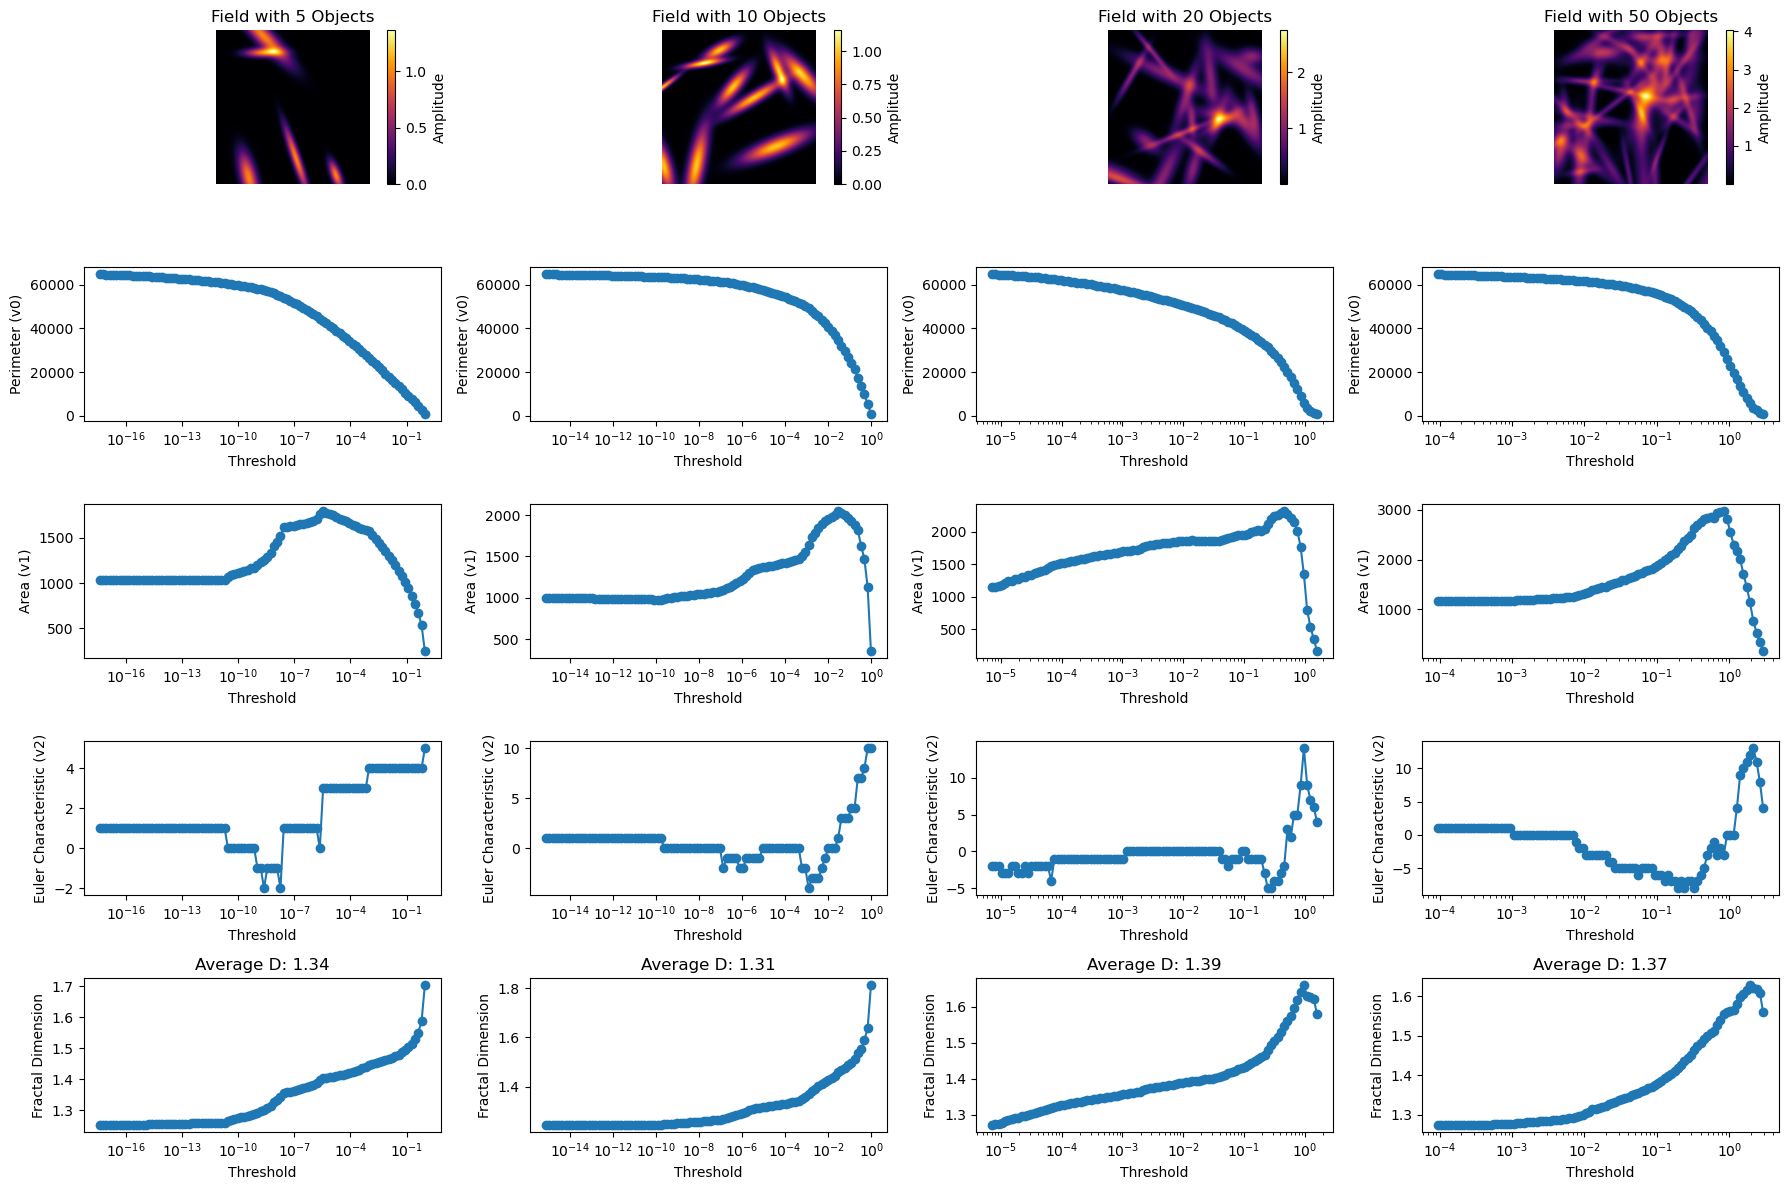

In [13]:
# Simulation parameters, only Filaments
shape = (256, 256)
max_sigma = 30
max_length = 100
max_width = 20
object_densities = [5, 10, 20, 50]
mix_ratio = 0

# Generate and analyze fields
fields = []
results = []
for num_objects in object_densities:
    field = create_mixed_field(shape, num_objects, max_sigma, max_length, max_width, mix_ratio)
    fields.append(field)
    results.append(minkowski_funct(field, threshold_min=np.percentile(field, 1), threshold_max=np.percentile(field, 99)))

# Visualize all Gaussians and their Minkowski functional results
plt.figure(figsize=(18, 12))

# First row: Gaussian images
for i, field in enumerate(fields):
    plt.subplot(5, len(fields), i + 1)
    plt.imshow(field, origin='lower', cmap='inferno', extent=[0, shape[0], 0, shape[1]])
    plt.title(f"Field with {object_densities[i]} Objects")
    plt.colorbar(label="Amplitude")
    plt.axis("off")

# Second, third, fourth rows: Minkowski functionals
labels = ["Perimeter (v0)", "Area (v1)", "Euler Characteristic (v2)", "Fractal Dimension"]

for j in range(4):  # One row for each functional
    for i, field in enumerate(fields):
        plt.subplot(5, len(fields), (j + 1) * len(fields) + i + 1)
        plt.plot(results[i]["thresholds"], results[i]["values"][j], 'o-')
        plt.xlabel("Threshold")
        plt.ylabel(labels[j])
        plt.xscale("log")
        if j == 3:  # For the fractal dimension row
            avg_fractal_dim = np.nanmean(results[i]["values"][j]) 
            plt.title(f"Average D: {avg_fractal_dim:.2f}")
            
plt.tight_layout()
plt.show()

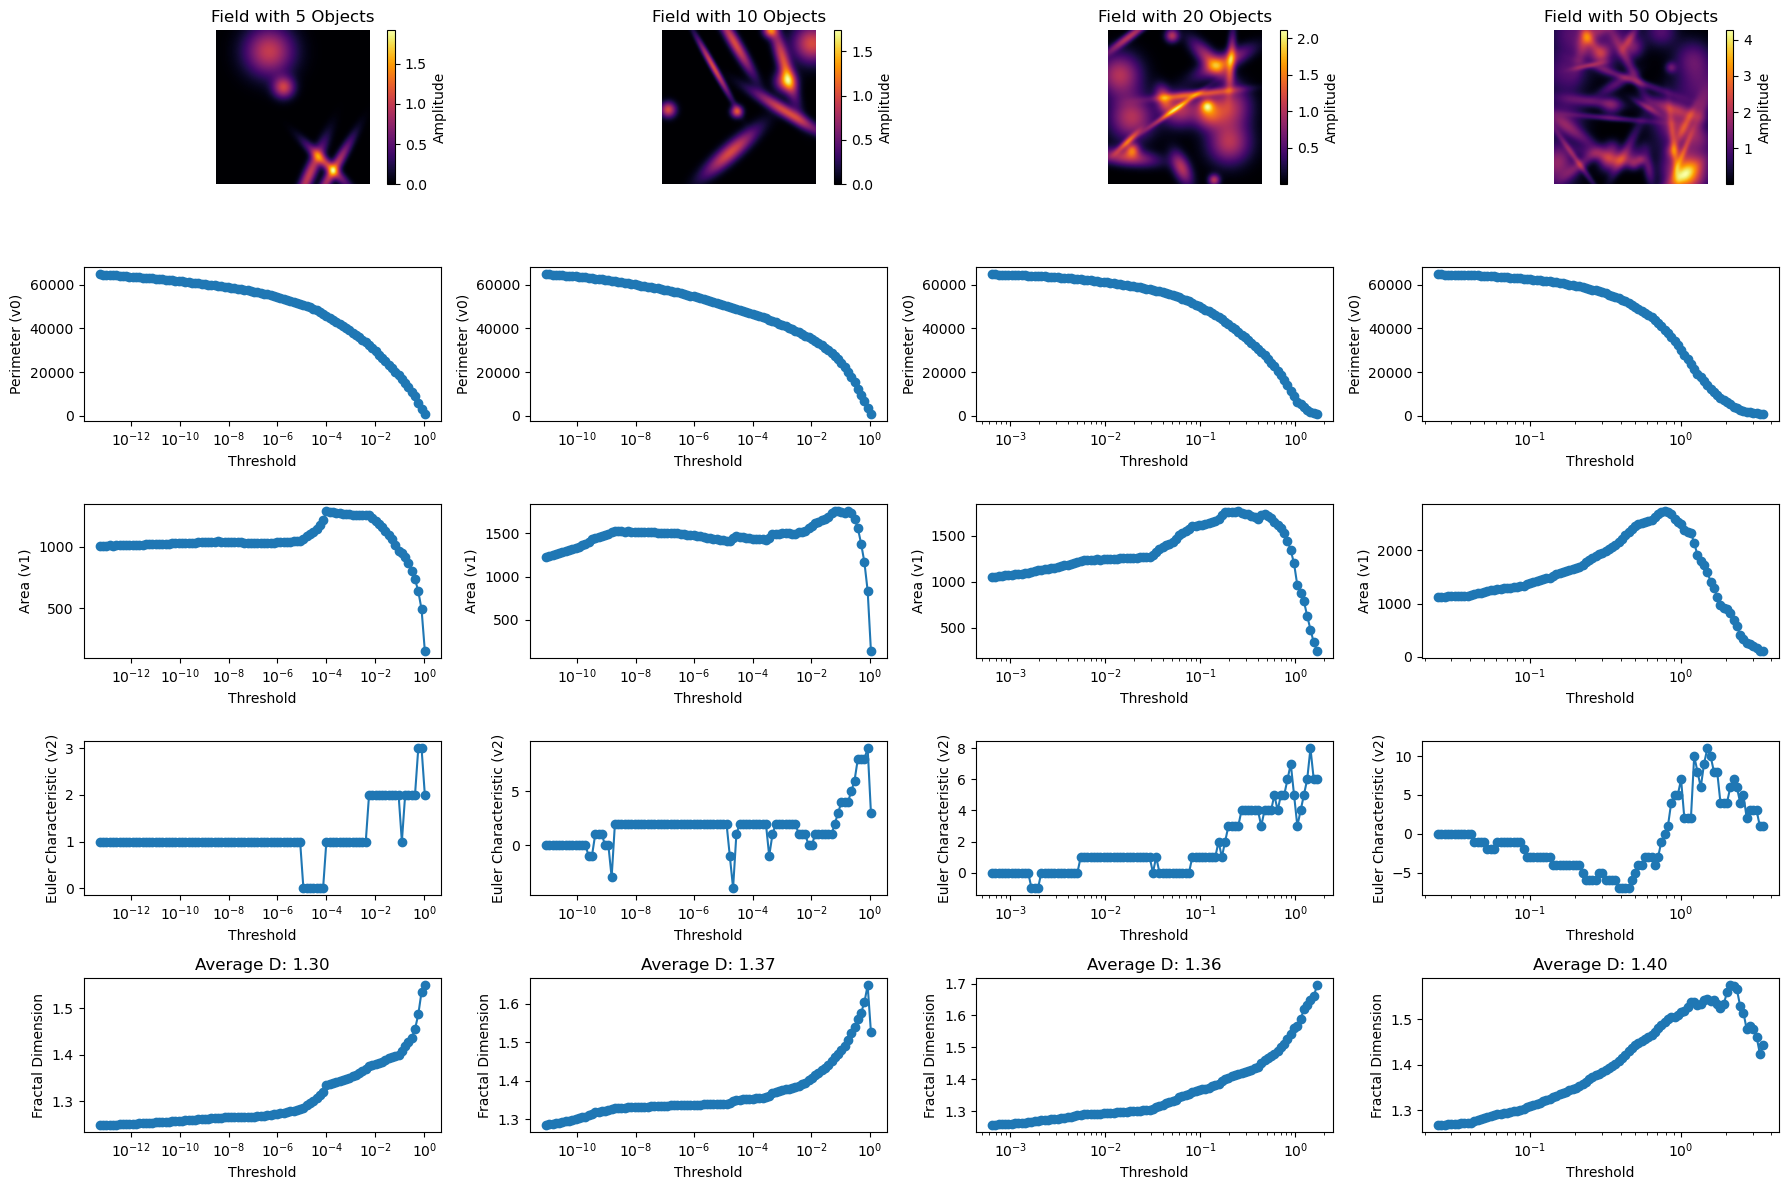

In [14]:
# Simulation parameters, only Gaussians
shape = (256, 256)
max_sigma = 30
max_length = 100
max_width = 20
object_densities = [5, 10, 20, 50]
mix_ratio = 0.5

# Generate and analyze fields
fields = []
results = []
for num_objects in object_densities:
    field = create_mixed_field(shape, num_objects, max_sigma, max_length, max_width, mix_ratio)
    fields.append(field)
    results.append(minkowski_funct(field, threshold_min=np.percentile(field, 1), threshold_max=np.percentile(field, 99)))

# Visualize all Gaussians and their Minkowski functional results
plt.figure(figsize=(18, 12))

# First row: Gaussian images
for i, field in enumerate(fields):
    plt.subplot(5, len(fields), i + 1)
    plt.imshow(field, origin='lower', cmap='inferno', extent=[0, shape[0], 0, shape[1]])
    plt.title(f"Field with {object_densities[i]} Objects")
    plt.colorbar(label="Amplitude")
    plt.axis("off")

# Second, third, fourth rows: Minkowski functionals
labels = ["Perimeter (v0)", "Area (v1)", "Euler Characteristic (v2)", "Fractal Dimension"]

for j in range(4):  # One row for each functional
    for i, field in enumerate(fields):
        plt.subplot(5, len(fields), (j + 1) * len(fields) + i + 1)
        plt.plot(results[i]["thresholds"], results[i]["values"][j], 'o-')
        plt.xlabel("Threshold")
        plt.ylabel(labels[j])
        plt.xscale("log")
        if j == 3:  # For the fractal dimension row
            avg_fractal_dim = np.nanmean(results[i]["values"][j]) 
            plt.title(f"Average D: {avg_fractal_dim:.2f}")
            
plt.tight_layout()
plt.show()

In [ ]:
# Sierpinski Triangle?